In [392]:
#Of the players who played at their estimated peak age in 2022, which will exceed their 2022 WAR metric?

In [393]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

In [394]:
#all players 1980-2022
ss_pos_df = pd.read_csv('ss_pos_df_clean.csv')
ss_pos_df.head(5)

Rk           Player  WAR  Season  Age  Team  Lg    G   PA   AB  ...  \
0  14374  Garret Anderson  0.1    1994   22     4   0    5   13   13  ...   
1  23359   Jorge Fabregas -0.6    1994   24     4   0   43  135  127  ...   
2   3805       Tim Salmon  2.6    1994   25     4   0  100  435  373  ...   
3   3805       Tim Salmon  2.6    1994   25     4   0  100  435  373  ...   
4  22287    Damion Easley -0.4    1994   24     4   0   88  355  316  ...   

   Peak_FG_SLG.2  Peak_FG_SLG.3  Peak_FG_OPS  Peak_Prev_WAR  Peak_Next_WAR  \
0          0.469          0.469        0.806            0.3            1.9   
1          0.373          0.373        0.693           -0.3           -0.4   
2          0.501          0.501        0.887            6.6            5.0   
3          0.323          0.323        0.628            2.8            0.7   
4          0.434          0.434        0.779            5.6            4.0   

   Peak_Pos_Cat  Exceed_Prev_WAR  Exceed_Peak_WAR  Team_WL  Games_played  
0             5              1.0              0.0    0.409      0.043478  
1             0              1.0              0.0    0.409      0.373913  
2             5              0.0              1.0    0.409      0.869565  
3             6              0.0              1.0    0.409      0.869565  
4             2              0.0              1.0    0.409      0.765217  

[5 rows x 127 columns]

In [395]:
#find rows to predict
ss_pos_df_2023 = ss_pos_df[(ss_pos_df['Peak_Season'] == 2022) & (ss_pos_df['Season'] == 2022)]

#test set
ss_pos_df_2023

Rk              Player  WAR  Season  Age  Team  Lg    G   PA   AB  \
10447   7405       Tyler O'Neill  1.3    2022   27    25   1   96  383  334   
10449    405         Tommy Edman  6.4    2022   27    25   1  153  630  577   
11977   5064   Anthony Santander  2.1    2022   27     2   0  152  647  574   
11978   2562         Jorge Mateo  3.4    2022   27     2   0  150  533  494   
12349   3251  Isiah Kiner-Falefa  3.0    2022   27    18   0  142  531  483   
12559   7237    Michael Brantley  1.3    2022   35    12   0   64  277  243   
12563   1387        Alex Bregman  4.5    2022   28    12   0  155  656  548   
12564   7254      Chas McCormick  1.3    2022   27    12   0  119  407  359   
12646  21429         Colin Moran -0.3    2022   29     7   1   42  128  109   
12649  20510         Max Schrock -0.3    2022   27     7   1   13   27   26   
12650  10093         Jake Fraley  0.6    2022   27     7   1   68  247  216   
12651  25384         Nick Senzel -1.3    2022   27     7   1  110  420  373   
12681  24479      Billy McKinney -0.8    2022   27    19   0   23   57   52   
12682   6081          Seth Brown  1.7    2022   29    19   0  150  555  500   
12758   1918   Willson Contreras  3.9    2022   30     5   1  113  487  416   
12759  14405     Jackson Frazier  0.1    2022   27     5   1   19   45   37   
12760  23252  Michael Hermosillo -0.6    2022   27     5   1   31   73   61   
12761   1457            Ian Happ  4.4    2022   27     5   1  158  641  573   
12762  15316        P.J. Higgins  0.0    2022   29     5   1   74  229  201   
12863   3560       J.P. Crawford  2.8    2022   27    23   0  145  603  518   
12897  18405        Tony Wolters -0.1    2022   30    14   1    2    4    4   
12899  17640      Hanser Alberto -0.1    2022   29    14   1   73  159  156   
13017  15581        Jason Vosler  0.0    2022   28    24   1   36  111   98   
13040   6853    Andrew Velazquez  1.4    2022   27     4   0  125  349  322   
13041  18925        Chad Wallach -0.1    2022   30     4   0   12   40   35   
13073   6473       Manuel Margot  1.5    2022   27    26   0   89  363  336   
13074   3533     Randy Arozarena  2.8    2022   27    26   0  153  645  586   
13075  12351          Luke Raley  0.3    2022   27    26   0   22   72   61   
13081   4053        Trevor Story  2.5    2022   29     3   0   94  396  357   
13084  13793        Jaylin Davis  0.2    2022   27     3   0   12   27   24   
13138   3274        Rhys Hoskins  2.9    2022   29    20   1  156  672  589   
13215  19724    Charlie Blackmon -0.2    2022   35     9   1  135  577  530   
13221  25134     Garrett Hampson -1.1    2022   27     9   1   90  226  199   
13251   7955    Andrew McCutchen  1.1    2022   35    15   1  134  580  515   
13258  11151       Mike Brosseau  0.5    2022   28    15   1   69  160  141   
13297  10086   Jeimer Candelario  0.6    2022   28    10   0  124  467  429   
13299   9668      Austin Meadows  0.7    2022   27    10   0   36  147  128   
13303  13725        Nomar Mazara  0.2    2022   27    22   1   55  171  159   
13318  22446    Travis Demeritte -0.4    2022   27     1   1   26   96   89   
13324    797       Carlos Correa  5.4    2022   27    16   0  136  590  522   
13331  18904          Nick Solak -0.1    2022   27    27   0   35   95   82   
13336  16818      Anthony Alford  0.0    2022   27    21   1    2    4    4   
13338   3306      Bryan Reynolds  2.9    2022   27    21   1  145  614  542   
13350   2933          Josh Rojas  3.2    2022   28     0   1  125  510  443   
13372   3734         Myles Straw  2.7    2022   27     8   0  152  596  535   

       ...  Peak_FG_SLG.2  Peak_FG_SLG.3  Peak_FG_OPS  Peak_Prev_WAR  \
10447  ...          0.392          0.392        0.700            6.3   
10449  ...          0.400          0.400        0.725            3.7   
11977  ...          0.455          0.455        0.773            0.2   
11978  ...          0.379          0.379        0.646           -0.4   
12349  ...     

In [396]:
#check one
ss_pos_df_2023[["FG_playerid","Season","Peak_Season","Age","Peak_Age","Prev_WAR","WAR","Next_WAR","Peak_Prev_WAR","Peak_WAR","Peak_Next_WAR","Exceed_Prev_WAR","Exceed_Peak_WAR"]][ss_pos_df_2023["FG_playerid"] == 14162]



FG_playerid  Season  Peak_Season  Age  Peak_Age  Prev_WAR  WAR  \
13324        14162    2022         2022   27        27       7.2  5.4   

       Next_WAR  Peak_Prev_WAR  Peak_WAR  Peak_Next_WAR  Exceed_Prev_WAR  \
13324       NaN            7.2       5.4            NaN              0.0   

       Exceed_Peak_WAR  
13324              NaN

In [397]:
#drop nans from batting_ss_peaks_merge2
#ss_pos_df_train = ss_pos_df[ss_pos_df['Peak_Next_WAR'].notna()]
#ss_pos_df_train = ss_pos_df[(ss_pos_df['Peak_Season'] != 2022) & (ss_pos_df['Season'] = 2022)]
ss_pos_df_train = ss_pos_df[ss_pos_df['Exceed_Peak_WAR'].notna()]
ss_pos_df_train = ss_pos_df_train[ss_pos_df_train['Exceed_Peak_WAR'] != '']
ss_pos_df_train = ss_pos_df_train[ss_pos_df_train['Exceed_Prev_WAR'] != '']

#train set
ss_pos_df_train

Rk           Player  WAR  Season  Age  Team  Lg    G   PA   AB  ...  \
0      14374  Garret Anderson  0.1    1994   22     4   0    5   13   13  ...   
1      23359   Jorge Fabregas -0.6    1994   24     4   0   43  135  127  ...   
2       3805       Tim Salmon  2.6    1994   25     4   0  100  435  373  ...   
3       3805       Tim Salmon  2.6    1994   25     4   0  100  435  373  ...   
4      22287    Damion Easley -0.4    1994   24     4   0   88  355  316  ...   
...      ...              ...  ...     ...  ...   ...  ..  ...  ...  ...  ...   
15709  22050   Darrell Miller -0.4    1984   26     4   0   17   45   41  ...   
15711  14752     Jerry Narron  0.1    1984   28     4   0   69  162  150  ...   
15712   5281      Gary Pettis  2.0    1984   26     4   0  140  466  397  ...   
15713  17394   Dick Schofield -0.1    1984   21     4   0  140  452  400  ...   
15714   8574      Rob Wilfong  1.0    1984   30     4   0  108  337  307  ...   

       Peak_FG_SLG.2  Peak_FG_SLG.3  Peak_FG_OPS  Peak_Prev_WAR  \
0              0.469          0.469        0.806            0.3   
1              0.373          0.373        0.693           -0.3   
2              0.501          0.501        0.887            6.6   
3              0.323          0.323        0.628            2.8   
4              0.434          0.434        0.779            5.6   
...              ...            ...          ...            ...   
15709          0.583          0.583        0.983           -0.4   
15711          0.305          0.305        0.598            0.1   
15712          0.323          0.323        0.670            2.0   
15713          0.297          0.297        0.660            2.5   
15714          0.339          0.339        0.632            0.7   

       Peak_Next_WAR  Peak_Pos_Cat  Exceed_Prev_WAR  Exceed_Peak_WAR  Team_WL  \
0                1.9             5              1.0              0.0    0.409   
1               -0.4             0              1.0              0.0    0.409   
2                5.0             5              0.0              1.0    0.409   
3                0.7             6              0.0              1.0    0.409   
4                4.0             2              0.0              1.0    0.409   
...              ...           ...              ...              ...      ...   
15709           -0.7             5              1.0              0.0    0.500   
15711           -0.2             0              0.0              0.0    0.500   
15712            5.1             5              1.0              1.0    0.500   
15713            0.8             4              0.0              0.0    0.500   
15714            1.0             2              0.0              1.0    0.500   

       Games_played  
0          0.043478  
1          0.373913  
2          0.869565  
3          0.869565  
4          0.765217  
...             ...  
15709      0.104938  
15711      0.425926  
15712      0.864198  
15713      0.864198  
15714      0.666667  

[14238 rows x 127 columns]

In [398]:
#check one
ss_pos_df_train[["FG_playerid","Season","Peak_Season","Age","Peak_Age","Prev_WAR","WAR","Next_WAR","Peak_Prev_WAR","Peak_WAR","Peak_Next_WAR","Exceed_Prev_WAR","Exceed_Peak_WAR"]][ss_pos_df_train["FG_playerid"] == 3797]



FG_playerid  Season  Peak_Season  Age  Peak_Age  Prev_WAR  WAR  \
1618          3797    2007         2010   24        27       0.8  3.2   
1632          3797    2008         2010   25        27       3.2  4.8   
1645          3797    2009         2010   26        27       4.8  0.5   
2070          3797    2005         2010   22        27       NaN  1.8   
2083          3797    2006         2010   23        27       1.8  0.8   
4219          3797    2011         2010   28        27       1.3  4.1   
4232          3797    2012         2010   29        27       4.1  3.3   
4242          3797    2013         2010   30        27       3.3  3.6   
7476          3797    2010         2010   27        27       0.5  1.3   
11646         3797    2014         2010   31        27       3.6  3.1   
12017         3797    2017         2010   34        27       2.1 -0.1   
12272         3797    2015         2010   32        27       3.1 -0.3   
12285         3797    2016         2010   33        27      -0.3  2.1   

       Next_WAR  Peak_Prev_WAR  Peak_WAR  Peak_Next_WAR  Exceed_Prev_WAR  \
1618        4.8            0.5       1.3            4.1              1.0   
1632        0.5            0.5       1.3            4.1              1.0   
1645        1.3            0.5       1.3            4.1              1.0   
2070        0.8            0.5       1.3            4.1              1.0   
2083        3.2            0.5       1.3            4.1              1.0   
4219        3.3            0.5       1.3            4.1              1.0   
4232        3.6            0.5       1.3            4.1              1.0   
4242        3.1            0.5       1.3            4.1              1.0   
7476        4.1            0.5       1.3            4.1              1.0   
11646      -0.3            0.5       1.3            4.1              1.0   
12017       NaN            0.5       1.3            4.1              1.0   
12272       2.1            0.5       1.3            4.1              1.0   
12285      -0.1            0.5       1.3            4.1              1.0   

       Exceed_Peak_WAR  
1618               1.0  
1632               1.0  
1645               1.0  
2070               1.0  
2083               1.0  
4219               1.0  
4232               1.0  
4242               1.0  
7476               1.0  
11646              1.0  
12017              1.0  
12272              1.0  
12285              1.0

In [399]:
#drop rows where Prev_WAR are null
ss_pos_df_train_2 = ss_pos_df_train.dropna(subset=['Prev_WAR'])

In [400]:
#check name
ss_pos_df_train_2[["FG_playerid","Season","Peak_Season","Age","Peak_Age","Prev_WAR","WAR","Next_WAR","Peak_Prev_WAR","Peak_WAR","Peak_Next_WAR","Exceed_Prev_WAR","Exceed_Peak_WAR"]][ss_pos_df_train_2["FG_playerid"] == 3797]



FG_playerid  Season  Peak_Season  Age  Peak_Age  Prev_WAR  WAR  \
1618          3797    2007         2010   24        27       0.8  3.2   
1632          3797    2008         2010   25        27       3.2  4.8   
1645          3797    2009         2010   26        27       4.8  0.5   
2083          3797    2006         2010   23        27       1.8  0.8   
4219          3797    2011         2010   28        27       1.3  4.1   
4232          3797    2012         2010   29        27       4.1  3.3   
4242          3797    2013         2010   30        27       3.3  3.6   
7476          3797    2010         2010   27        27       0.5  1.3   
11646         3797    2014         2010   31        27       3.6  3.1   
12017         3797    2017         2010   34        27       2.1 -0.1   
12272         3797    2015         2010   32        27       3.1 -0.3   
12285         3797    2016         2010   33        27      -0.3  2.1   

       Next_WAR  Peak_Prev_WAR  Peak_WAR  Peak_Next_WAR  Exceed_Prev_WAR  \
1618        4.8            0.5       1.3            4.1              1.0   
1632        0.5            0.5       1.3            4.1              1.0   
1645        1.3            0.5       1.3            4.1              1.0   
2083        3.2            0.5       1.3            4.1              1.0   
4219        3.3            0.5       1.3            4.1              1.0   
4232        3.6            0.5       1.3            4.1              1.0   
4242        3.1            0.5       1.3            4.1              1.0   
7476        4.1            0.5       1.3            4.1              1.0   
11646      -0.3            0.5       1.3            4.1              1.0   
12017       NaN            0.5       1.3            4.1              1.0   
12272       2.1            0.5       1.3            4.1              1.0   
12285      -0.1            0.5       1.3            4.1              1.0   

       Exceed_Peak_WAR  
1618               1.0  
1632               1.0  
1645               1.0  
2083               1.0  
4219               1.0  
4232               1.0  
4242               1.0  
7476               1.0  
11646              1.0  
12017              1.0  
12272              1.0  
12285              1.0

In [401]:
#grab player name
ss_pos_df_train_2_player = ss_pos_df_train_2['Player'].reset_index(drop=True)

In [402]:
#drop Next_WAR & Peak_Next_WAR cols 
ss_pos_df_train_2 = ss_pos_df_train_2.drop(['Next_WAR','Peak_Next_WAR','Player'], axis=1)

In [403]:
#check one
ss_pos_df_train_2[["FG_playerid","Season","Peak_Season","Age","Peak_Age","Prev_WAR","WAR","Peak_Prev_WAR","Peak_WAR","Exceed_Prev_WAR","Exceed_Peak_WAR"]][ss_pos_df_train_2["FG_playerid"] == 3797]



FG_playerid  Season  Peak_Season  Age  Peak_Age  Prev_WAR  WAR  \
1618          3797    2007         2010   24        27       0.8  3.2   
1632          3797    2008         2010   25        27       3.2  4.8   
1645          3797    2009         2010   26        27       4.8  0.5   
2083          3797    2006         2010   23        27       1.8  0.8   
4219          3797    2011         2010   28        27       1.3  4.1   
4232          3797    2012         2010   29        27       4.1  3.3   
4242          3797    2013         2010   30        27       3.3  3.6   
7476          3797    2010         2010   27        27       0.5  1.3   
11646         3797    2014         2010   31        27       3.6  3.1   
12017         3797    2017         2010   34        27       2.1 -0.1   
12272         3797    2015         2010   32        27       3.1 -0.3   
12285         3797    2016         2010   33        27      -0.3  2.1   

       Peak_Prev_WAR  Peak_WAR  Exceed_Prev_WAR  Exceed_Peak_WAR  
1618             0.5       1.3              1.0              1.0  
1632             0.5       1.3              1.0              1.0  
1645             0.5       1.3              1.0              1.0  
2083             0.5       1.3              1.0              1.0  
4219             0.5       1.3              1.0              1.0  
4232             0.5       1.3              1.0              1.0  
4242             0.5       1.3              1.0              1.0  
7476             0.5       1.3              1.0              1.0  
11646            0.5       1.3              1.0              1.0  
12017            0.5       1.3              1.0              1.0  
12272            0.5       1.3              1.0              1.0  
12285            0.5       1.3              1.0              1.0

In [404]:
#drop rows where Prev_WAR & Next_WAR are null
#ss_pos_df_test_2 = ss_pos_df_test.dropna(subset=['Prev_WAR','Next_WAR'])
ss_pos_df_2023[['Prev_WAR','WAR','Next_WAR','Peak_Prev_WAR','Peak_WAR','Peak_Next_WAR']]

Prev_WAR  WAR  Next_WAR  Peak_Prev_WAR  Peak_WAR  Peak_Next_WAR
10447       6.3  1.3       NaN            6.3       1.3            NaN
10449       3.7  6.4       NaN            3.7       6.4            NaN
11977       0.2  2.1       NaN            0.2       2.1            NaN
11978      -0.4  3.4       NaN           -0.4       3.4            NaN
12349       3.7  3.0       NaN            3.7       3.0            NaN
12559       2.5  1.3       NaN            2.5       1.3            NaN
12563       2.1  4.5       NaN            2.1       4.5            NaN
12564       2.3  1.3       NaN            2.3       1.3            NaN
12646       0.0 -0.3       NaN            0.0      -0.3            NaN
12649      -0.1 -0.3       NaN           -0.1      -0.3            NaN
12650       1.6  0.6       NaN            1.6       0.6            NaN
12651      -0.4 -1.3       NaN           -0.4      -1.3            NaN
12681       0.1 -0.8       NaN            0.1      -0.8            NaN
12682       1.4  1.7       NaN            1.4       1.7            NaN
12758       4.1  3.9       NaN            4.1       3.9            NaN
12759      -1.4  0.1       NaN           -1.4       0.1            NaN
12760       0.1 -0.6       NaN            0.1      -0.6            NaN
12761       1.6  4.4       NaN            1.6       4.4            NaN
12762      -0.4  0.0       NaN           -0.4       0.0            NaN
12863       3.8  2.8       NaN            3.8       2.8            NaN
12897      -0.3 -0.1       NaN           -0.3      -0.1            NaN
12899       0.4 -0.1       NaN            0.4      -0.1            NaN
13017      -0.8  0.0       NaN           -0.8       0.0            NaN
13040       0.0  1.4       NaN            0.0       1.4            NaN
13041      -0.8 -0.1       NaN           -0.8      -0.1            NaN
13073       2.8  1.5       NaN            2.8       1.5            NaN
13074       4.1  2.8       NaN            4.1       2.8            NaN
13075      -0.5  0.3       NaN           -0.5       0.3            NaN
13081       4.2  2.5       NaN            4.2       2.5            NaN
13084      -0.1  0.2       NaN           -0.1       0.2            NaN
13138       2.0  2.9       NaN            2.0       2.9            NaN
13215       1.0 -0.2       NaN            1.0      -0.2            NaN
13221       0.7 -1.1       NaN            0.7      -1.1            NaN
13251       1.4  1.1       NaN            1.4       1.1            NaN
13258       1.0  0.5       NaN            1.0       0.5            NaN
13297       3.8  0.6       NaN            3.8       0.6            NaN
13299       2.0  0.7       NaN            2.0       0.7            NaN
13303      -0.3  0.2       NaN           -0.3       0.2            NaN
13318       0.0 -0.4       NaN            0.0      -0.4            NaN
13324       7.2  5.4       NaN            7.2       5.4            NaN
13331       1.0 -0.1       NaN            1.0      -0.1            NaN
13336       0.4  0.0       NaN            0.4       0.0            NaN
13338       6.0  2.9       NaN            6.0       2.9            NaN
13350       0.8  3.2       NaN            0.8       3.2            NaN
13372      -0.4  2.7       NaN           -0.4       2.7            NaN

In [405]:
#drop rows where Prev_WAR are null
ss_pos_df_2023_2 = ss_pos_df_2023.dropna(subset=['Prev_WAR'])

In [406]:
#grab player name
ss_pos_df_2023_2_player = ss_pos_df_2023_2['Player'].reset_index(drop=True)

In [407]:
#drop Next_WAR & Peak_Next_WAR cols 
ss_pos_df_2023_2 = ss_pos_df_2023_2.drop(['Next_WAR','Peak_Next_WAR','Player'], axis=1)

In [408]:
#check
ss_pos_df_2023_2

Rk  WAR  Season  Age  Team  Lg    G   PA   AB   R  ...  Peak_FG_OBP  \
10447   7405  1.3    2022   27    25   1   96  383  334  56  ...        0.308   
10449    405  6.4    2022   27    25   1  153  630  577  95  ...        0.324   
11977   5064  2.1    2022   27     2   0  152  647  574  78  ...        0.318   
11978   2562  3.4    2022   27     2   0  150  533  494  63  ...        0.267   
12349   3251  3.0    2022   27    18   0  142  531  483  66  ...        0.314   
12559   7237  1.3    2022   35    12   0   64  277  243  28  ...        0.370   
12563   1387  4.5    2022   28    12   0  155  656  548  93  ...        0.366   
12564   7254  1.3    2022   27    12   0  119  407  359  47  ...        0.332   
12646  21429 -0.3    2022   29     7   1   42  128  109  11  ...        0.305   
12649  20510 -0.3    2022   27     7   1   13   27   26   1  ...        0.185   
12650  10093  0.6    2022   27     7   1   68  247  216  33  ...        0.344   
12651  25384 -1.3    2022   27     7   1  110  420  373  45  ...        0.296   
12681  24479 -0.8    2022   27    19   0   23   57   52   3  ...        0.158   
12682   6081  1.7    2022   29    19   0  150  555  500  55  ...        0.305   
12758   1918  3.9    2022   30     5   1  113  487  416  65  ...        0.349   
12759  14405  0.1    2022   27     5   1   19   45   37   4  ...        0.356   
12760  23252 -0.6    2022   27     5   1   31   73   61   7  ...        0.250   
12761   1457  4.4    2022   27     5   1  158  641  573  72  ...        0.342   
12762  15316  0.0    2022   29     5   1   74  229  201  23  ...        0.310   
12863   3560  2.8    2022   27    23   0  145  603  518  57  ...        0.339   
12897  18405 -0.1    2022   30    14   1    2    4    4   0  ...        0.000   
12899  17640 -0.1    2022   29    14   1   73  159  156  13  ...        0.258   
13017  15581  0.0    2022   28    24   1   36  111   98  14  ...        0.342   
13040   6853  1.4    2022   27     4   0  125  349  322  37  ...        0.236   
13041  18925 -0.1    2022   30     4   0   12   40   35   3  ...        0.231   
13073   6473  1.5    2022   27    26   0   89  363  336  36  ...        0.325   
13074   3533  2.8    2022   27    26   0  153  645  586  72  ...        0.327   
13075  12351  0.3    2022   27    26   0   22   72   61   7  ...        0.306   
13081   4053  2.5    2022   29     3   0   94  396  357  53  ...        0.303   
13084  13793  0.2    2022   27     3   0   12   27   24   4  ...        0.407   
13138   3274  2.9    2022   29    20   1  156  672  589  81  ...        0.332   
13215  19724 -0.2    2022   35     9   1  135  577  530  60  ...        0.314   
13221  25134 -1.1    2022   27     9   1   90  226  199  29  ...        0.287   
13251   7955  1.1    2022   35    15   1  134  580  515  66  ...        0.316   
13258  11151  0.5    2022   28    15   1   69  160  141  15  ...        0.344   
13297  10086  0.6    2022   28    10   0  124  467  429  49  ...        0.272   
13299   9668  0.7    2022   27    10   0   36  147  128   9  ...        0.347   
13303  13725  0.2    2022   27    22   1   55  171  159  16  ...        0.316   
13318  22446 -0.4    2022   27     1   1   26   96   89   9  ...        0.260   
13324    797  5.4    2022   27    16   0  136  590  522  70  ...        0.366   
13331  18904 -0.1    2022   27    27   0   35   95   82  14  ...        0.309   
13336  16818  0.0    2022   27    21   1    2    4    4   0  ...        0.250   
13338   3306  2.9    2022   27    21   1  145  614  542  74  ...        0.345   
13350   2933  3.2    2022   28     0   1  125  510  443  66  ...        0.349   
13372   3734  2.7    2022   27     8   0  152  596  535  72  ...        0.291   

       Peak_FG_SLG.2  Peak_FG_SLG.3  Peak_FG_OPS  Peak_Prev_WAR  Peak_Pos_Cat  \
10447          0.392          0.392        0.700            6.3             5   
10449          0.400          0.400        0.725            3.7             4   
11977          0.455          0.455     

In [409]:
#check correlations

In [410]:
#break into multiple datasets
ss_pos_df_train_2_1 = ss_pos_df_train_2.iloc[:, 0:25]
ss_pos_df_train_2_2 = ss_pos_df_train_2.iloc[:, 26:50]
ss_pos_df_train_2_3 = ss_pos_df_train_2.iloc[:, 51:75]
ss_pos_df_train_2_4 = ss_pos_df_train_2.iloc[:, 76:]

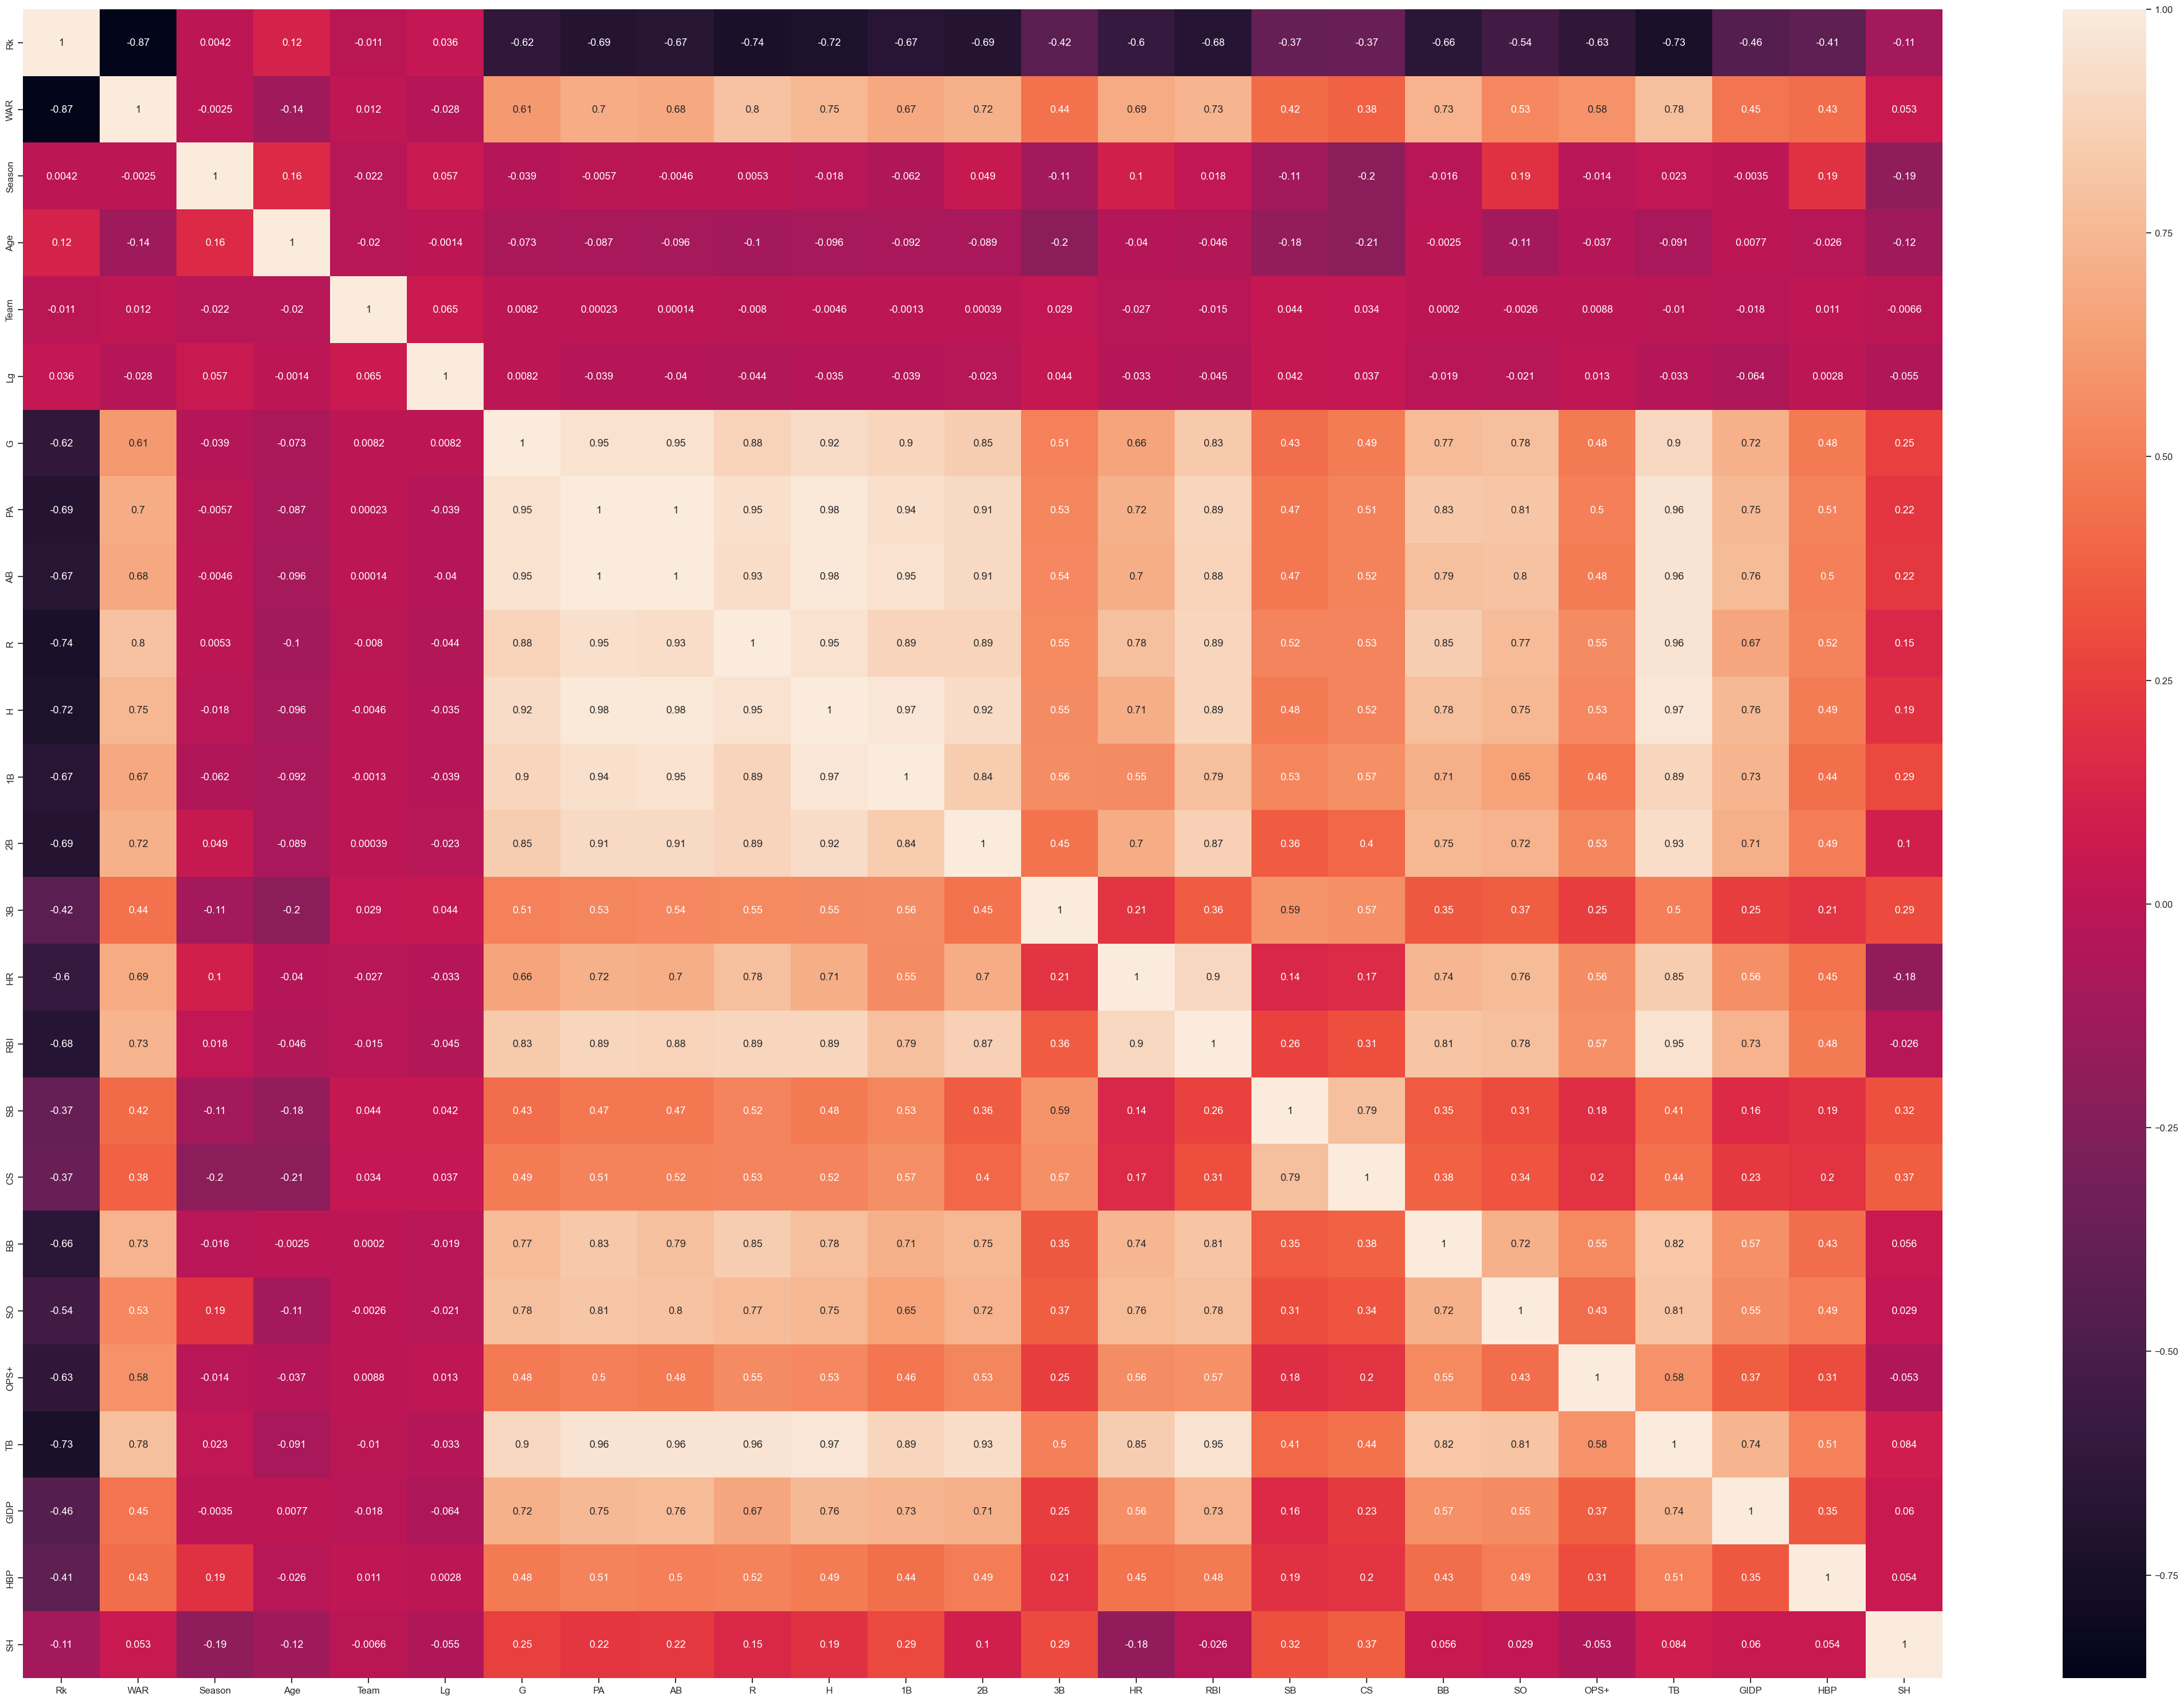

In [411]:
#correlation
X = ss_pos_df_train_2_1.values
N, M = X.shape
#Average of features
Xavg = np.zeros(M) 
for i in range(M):
    Xavg[i] = ss_pos_df_train_2_1.iloc[:,i].mean()

Xcor = np.zeros((M,M))
for x in range(M):
    for y in range(M):
        Xcor[x,y] = np.sum((X[:,x] - Xavg[x]) * (X[:,y] - Xavg[y])) / ((np.sqrt(np.sum((X[:,x] - Xavg[x])**2))) * (np.sqrt(np.sum((X[:,y] - Xavg[y])**2))))

cols = ss_pos_df_train_2_1.columns
sns.heatmap(Xcor, annot=True, xticklabels=cols, yticklabels=cols)
sns.set(rc = {'figure.figsize':(50,35)})
plt.show()

In [412]:
#G & PA, AB, R, H, 1B, 2B, RBI, SO, TB

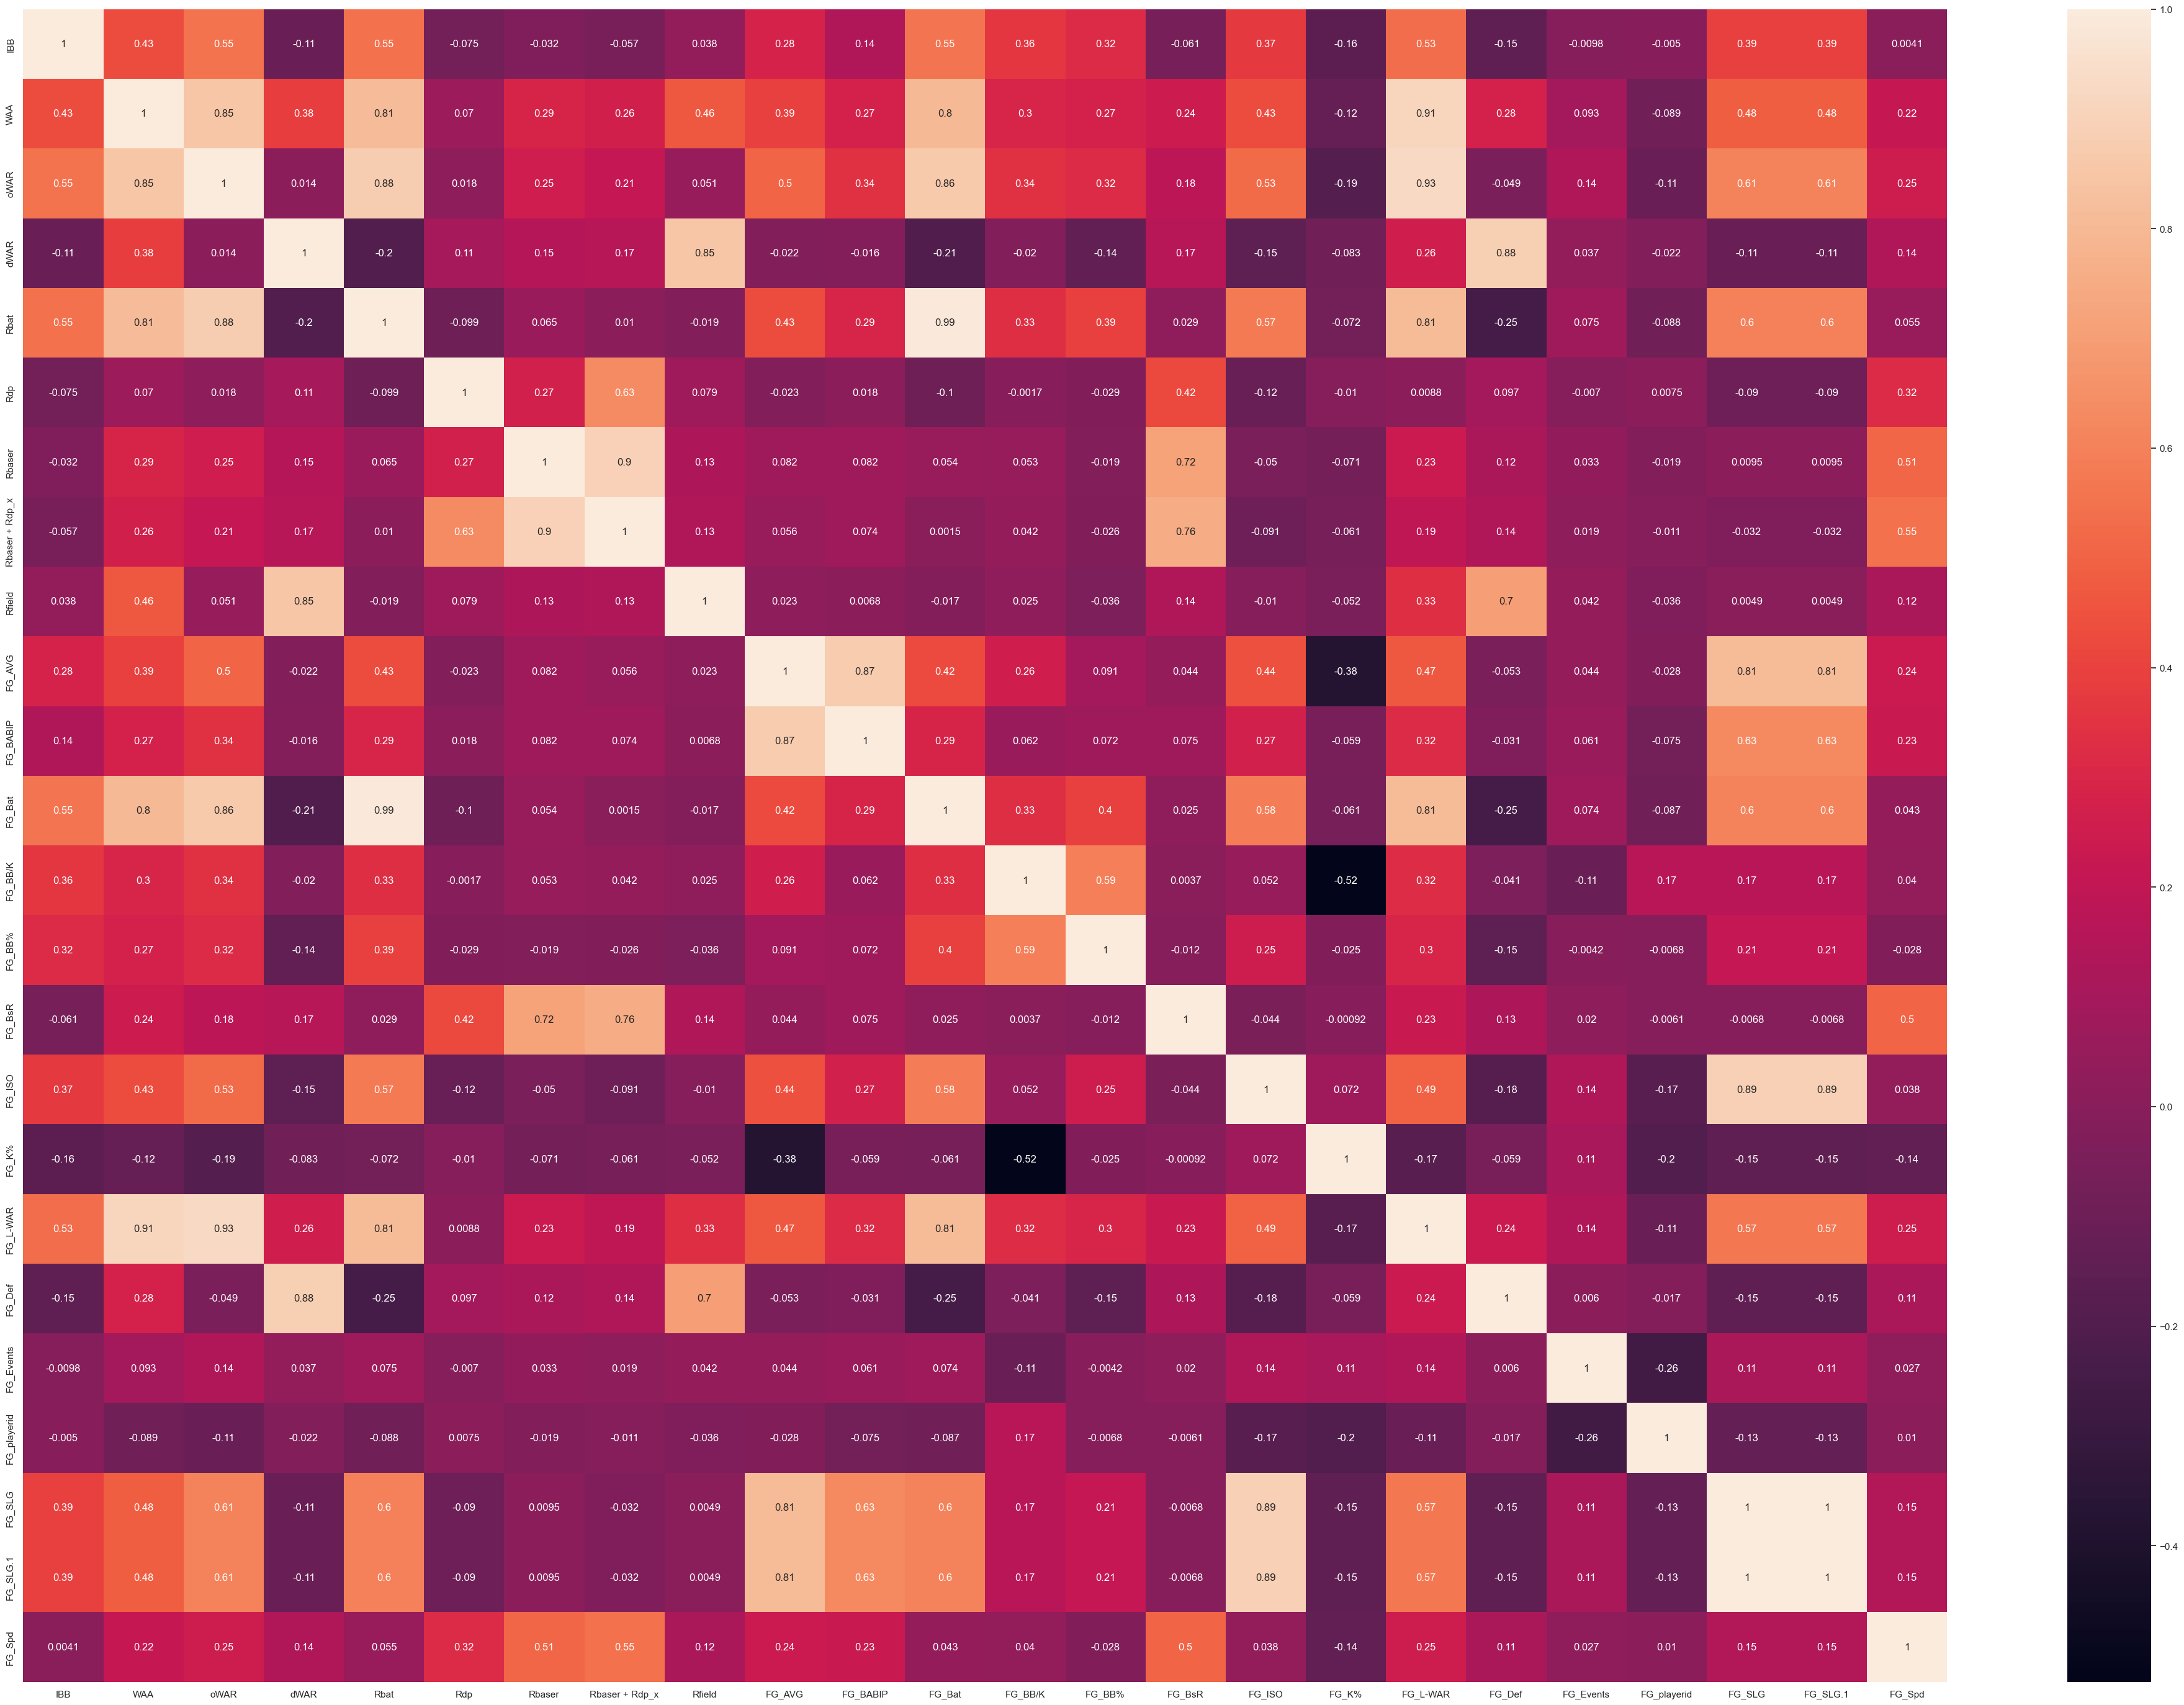

In [413]:
#correlation
X = ss_pos_df_train_2_2.values
N, M = X.shape
#Average of features
Xavg = np.zeros(M) 
for i in range(M):
    Xavg[i] = ss_pos_df_train_2_2.iloc[:,i].mean()

Xcor = np.zeros((M,M))
for x in range(M):
    for y in range(M):
        Xcor[x,y] = np.sum((X[:,x] - Xavg[x]) * (X[:,y] - Xavg[y])) / ((np.sqrt(np.sum((X[:,x] - Xavg[x])**2))) * (np.sqrt(np.sum((X[:,y] - Xavg[y])**2))))

cols = ss_pos_df_train_2_2.columns
sns.heatmap(Xcor, annot=True, xticklabels=cols, yticklabels=cols)
sns.set(rc = {'figure.figsize':(30,15)})
plt.show()

In [414]:
#WAA & dWAR, Rbat, FG_Bat, FG_L-WAR
#dWAR & Rbat, FG_Bat, FG_Def
#Rbat & WAA, dWAR, FG_Bat, FG_L-WAR
#Rbaser & Rbaser + Rdp_x
#Rfield & dWAR
#FG_AVG & FG_BABIP, FG_SLG
#FG_Bat & WAA, dWAR, Rbat, FG_L-WAR
#FG_L-WAR & WAA, dWAR, Rbat, FG_Bat
#FG_Def & dWAR
#FG_SLG & FG_ISO, FG_AVG

#2 FG_SLG?

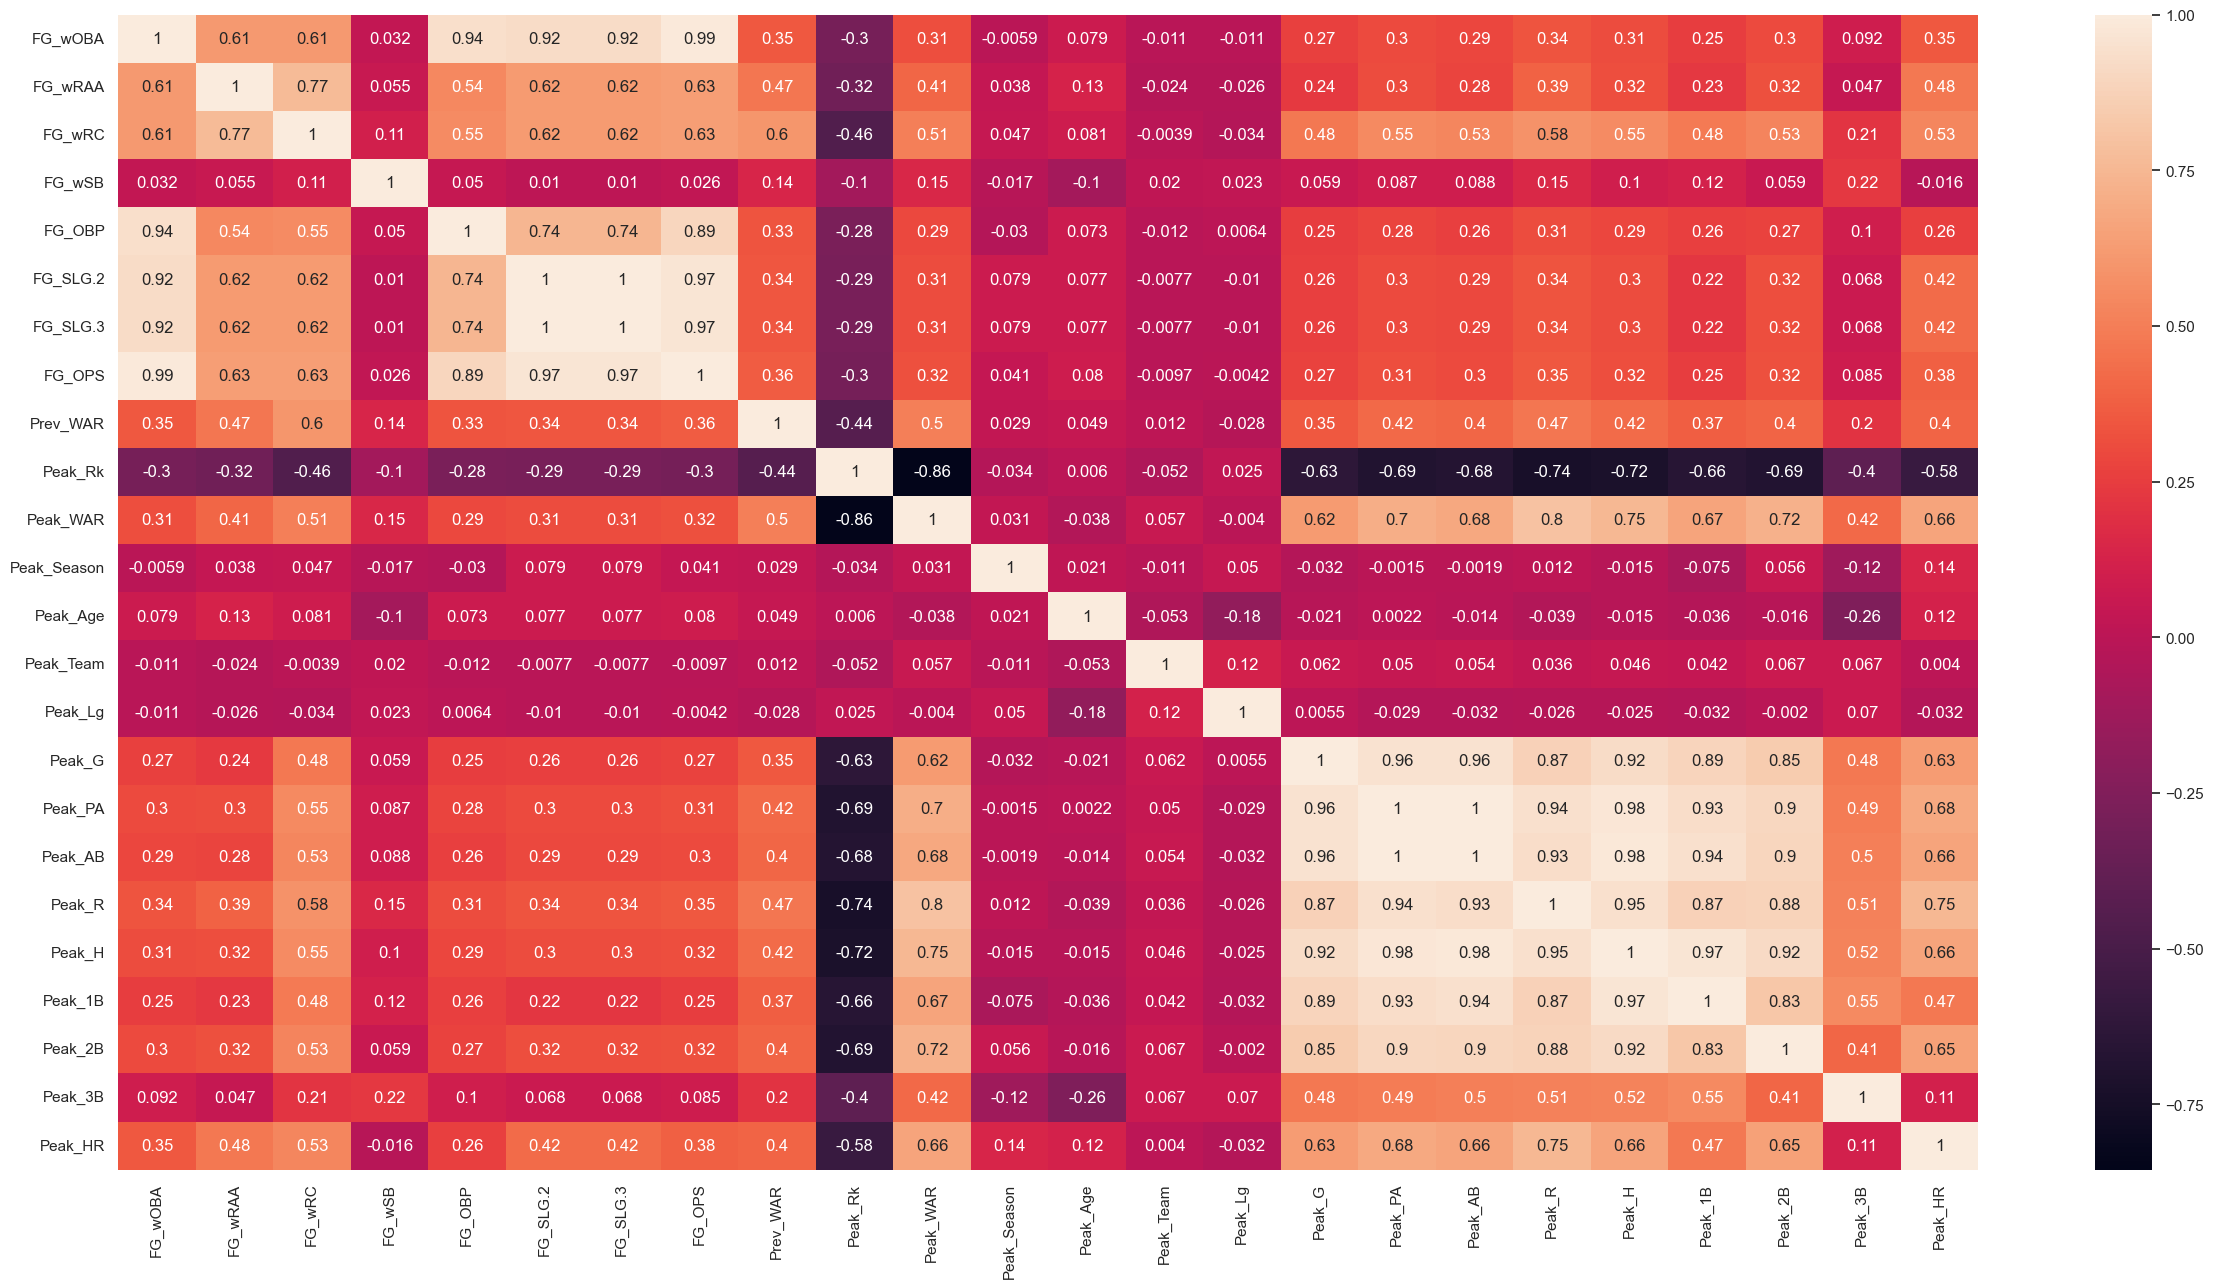

In [415]:
#correlation
X = ss_pos_df_train_2_3.values
N, M = X.shape
#Average of features
Xavg = np.zeros(M) 
for i in range(M):
    Xavg[i] = ss_pos_df_train_2_3.iloc[:,i].mean()

Xcor = np.zeros((M,M))
for x in range(M):
    for y in range(M):
        Xcor[x,y] = np.sum((X[:,x] - Xavg[x]) * (X[:,y] - Xavg[y])) / ((np.sqrt(np.sum((X[:,x] - Xavg[x])**2))) * (np.sqrt(np.sum((X[:,y] - Xavg[y])**2))))

cols = ss_pos_df_train_2_3.columns
sns.heatmap(Xcor, annot=True, xticklabels=cols, yticklabels=cols)
sns.set(rc = {'figure.figsize':(30,15)})
plt.show()

In [416]:
#FG_WOBA & FG_OBP, FG_SLG, FG_OPS
#FG_OBP & FG_OPS
#FG_SLG & FG_OPS


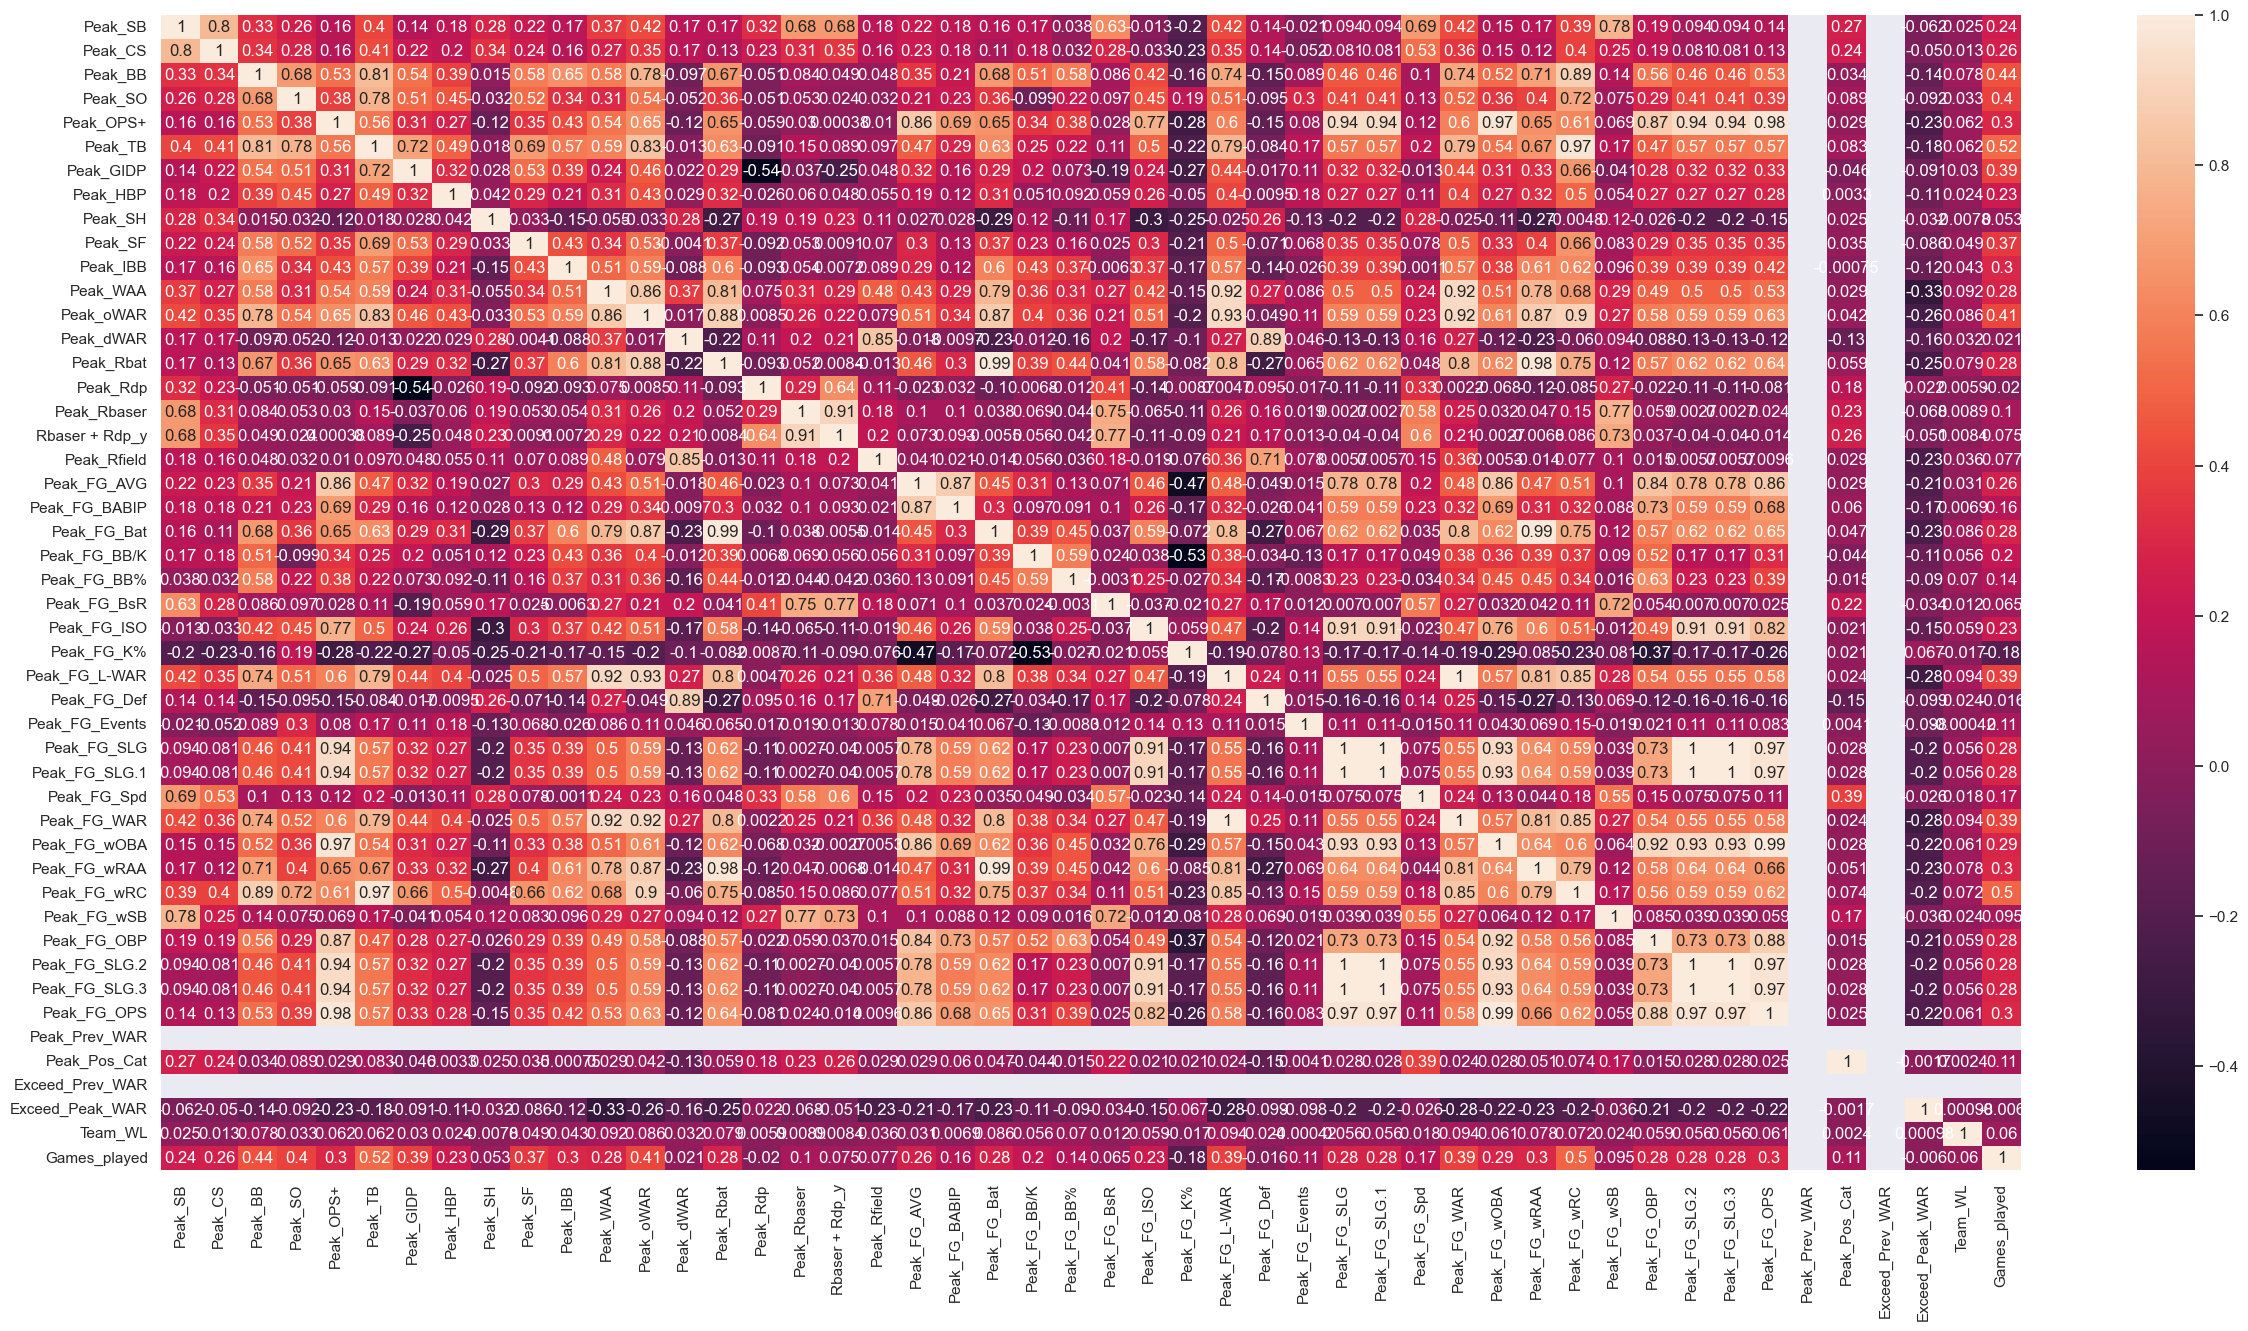

In [417]:
#correlation
X = ss_pos_df_train_2_4.values
N, M = X.shape
#Average of features
Xavg = np.zeros(M) 
for i in range(M):
    Xavg[i] = ss_pos_df_train_2_4.iloc[:,i].mean()

Xcor = np.zeros((M,M))
for x in range(M):
    for y in range(M):
        Xcor[x,y] = np.sum((X[:,x] - Xavg[x]) * (X[:,y] - Xavg[y])) / ((np.sqrt(np.sum((X[:,x] - Xavg[x])**2))) * (np.sqrt(np.sum((X[:,y] - Xavg[y])**2))))

cols = ss_pos_df_train_2_4.columns
sns.heatmap(Xcor, annot=True, xticklabels=cols, yticklabels=cols)
sns.set(rc = {'figure.figsize':(30,15)})
plt.show()

In [418]:
#drop highly correlated features
ss_pos_df_train_2 = ss_pos_df_train_2.drop(['Peak_G','G','Peak_PA','PA','Peak_AB','AB','Peak_R','R','Peak_H','H','Peak_1B','1B','Peak_2B','2B','Peak_RBI','RBI','Peak_SO','SO','Peak_TB','TB','WAA','Peak_WAA','dWAR','Peak_dWAR','Rbat','Peak_Rbat','FG_Bat','Peak_FG_Bat','FG_L-WAR','Peak_FG_L-WAR','Rbaser + Rdp_x','FG_SLG','FG_OBP','Peak_FG_OBP'], axis=1)


In [419]:
#break into multiple datasets for correlations
ss_pos_df_train_2_1 = ss_pos_df_train_2.iloc[:, 0:25]
ss_pos_df_train_2_2 = ss_pos_df_train_2.iloc[:, 26:50]
ss_pos_df_train_2_3 = ss_pos_df_train_2.iloc[:, 51:75]
ss_pos_df_train_2_4 = ss_pos_df_train_2.iloc[:, 76:]

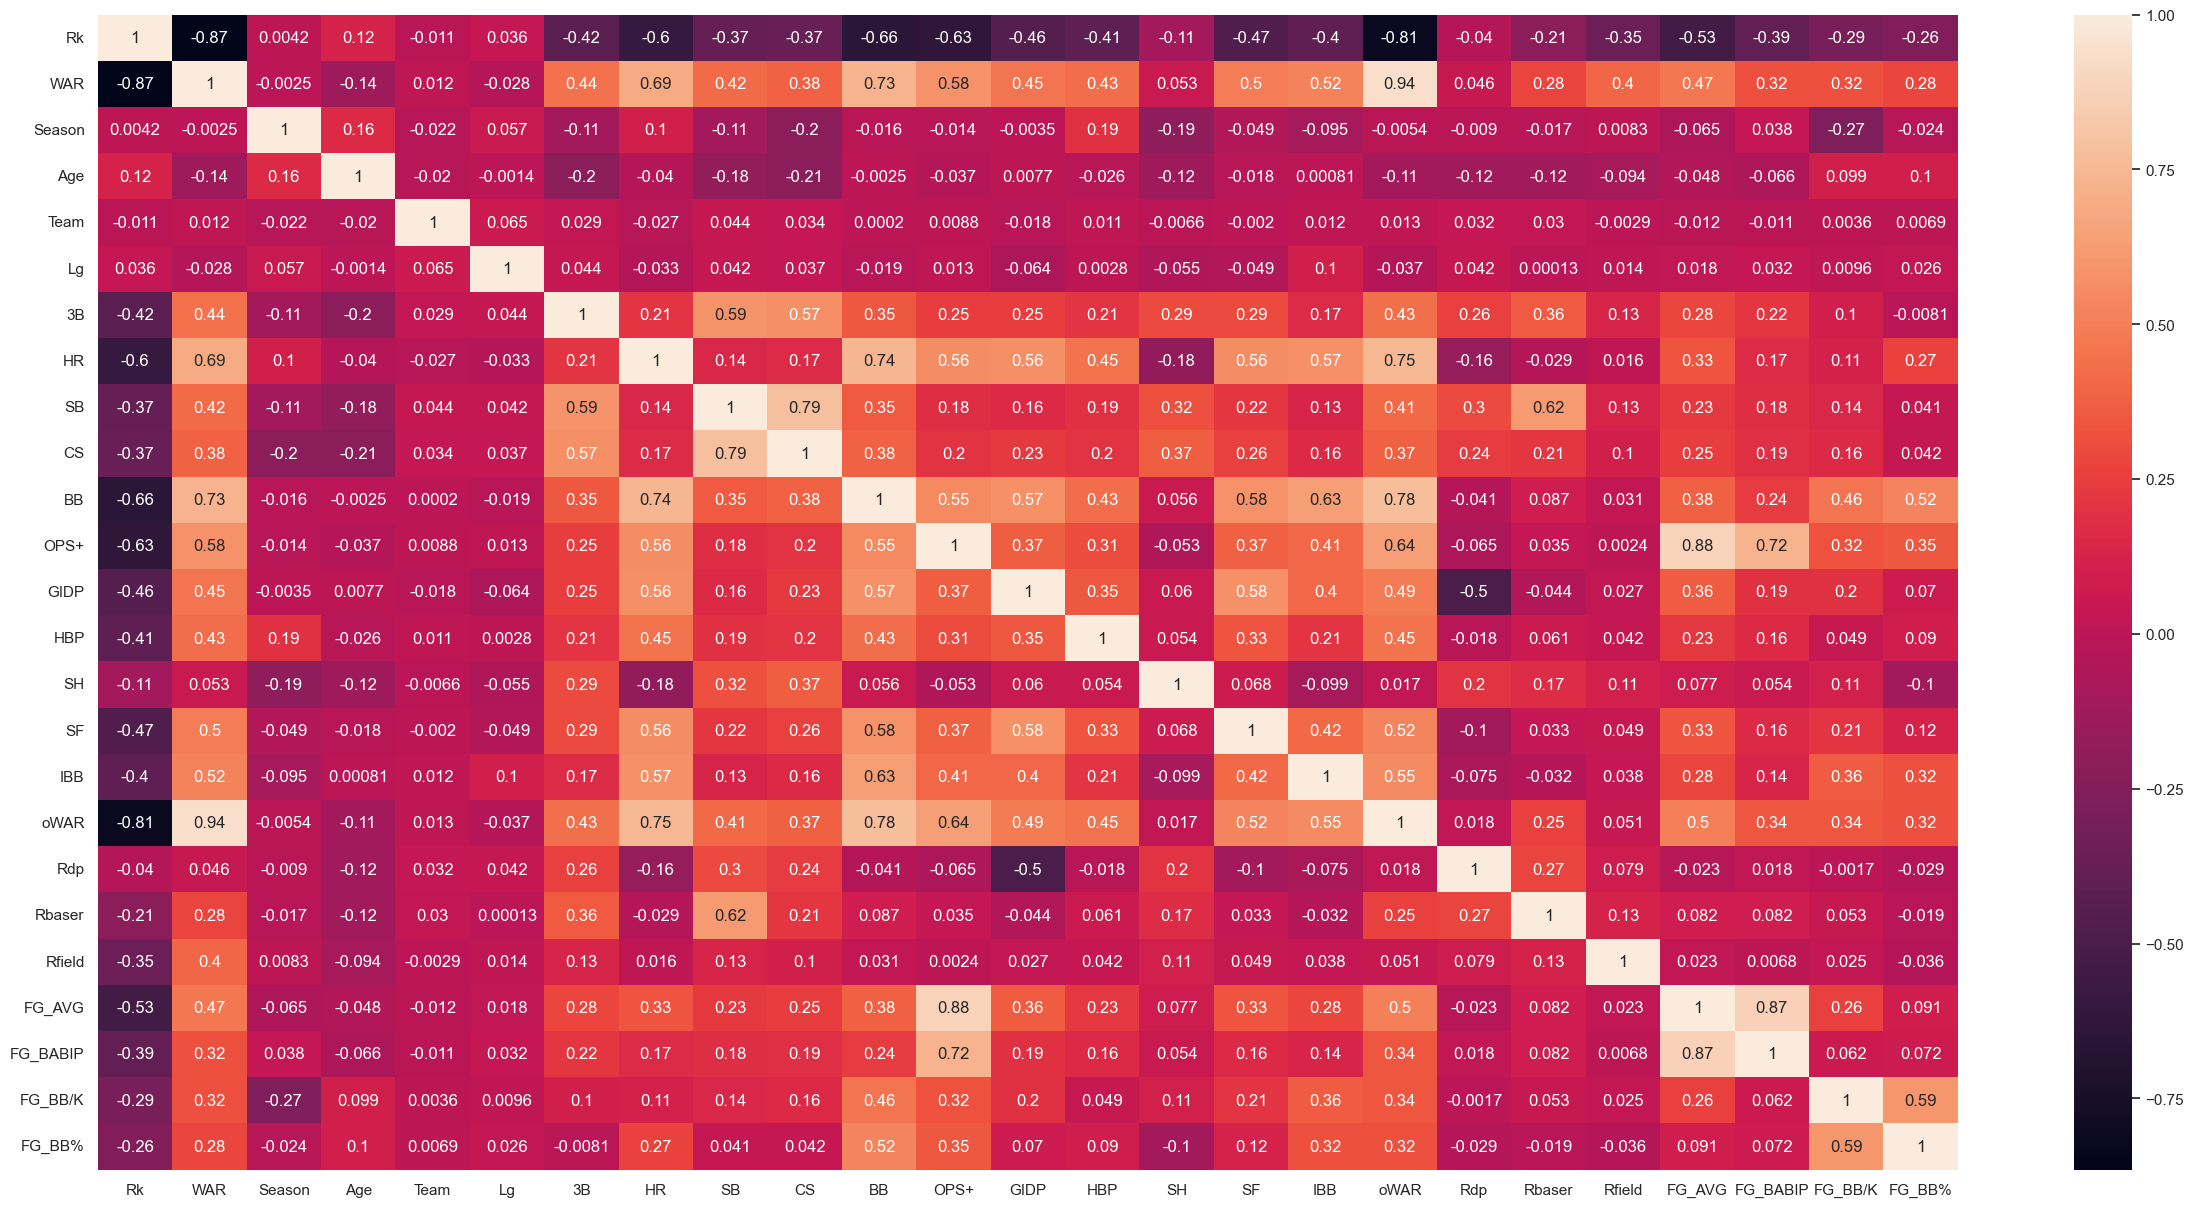

In [420]:
#correlation
X = ss_pos_df_train_2_1.values
N, M = X.shape
#Average of features
Xavg = np.zeros(M) 
for i in range(M):
    Xavg[i] = ss_pos_df_train_2_1.iloc[:,i].mean()

Xcor = np.zeros((M,M))
for x in range(M):
    for y in range(M):
        Xcor[x,y] = np.sum((X[:,x] - Xavg[x]) * (X[:,y] - Xavg[y])) / ((np.sqrt(np.sum((X[:,x] - Xavg[x])**2))) * (np.sqrt(np.sum((X[:,y] - Xavg[y])**2))))

cols = ss_pos_df_train_2_1.columns
sns.heatmap(Xcor, annot=True, xticklabels=cols, yticklabels=cols)
sns.set(rc = {'figure.figsize':(50,35)})
plt.show()

In [421]:
#WAR & oWAR
#FG_AVG & OPS+, FG_BABIP

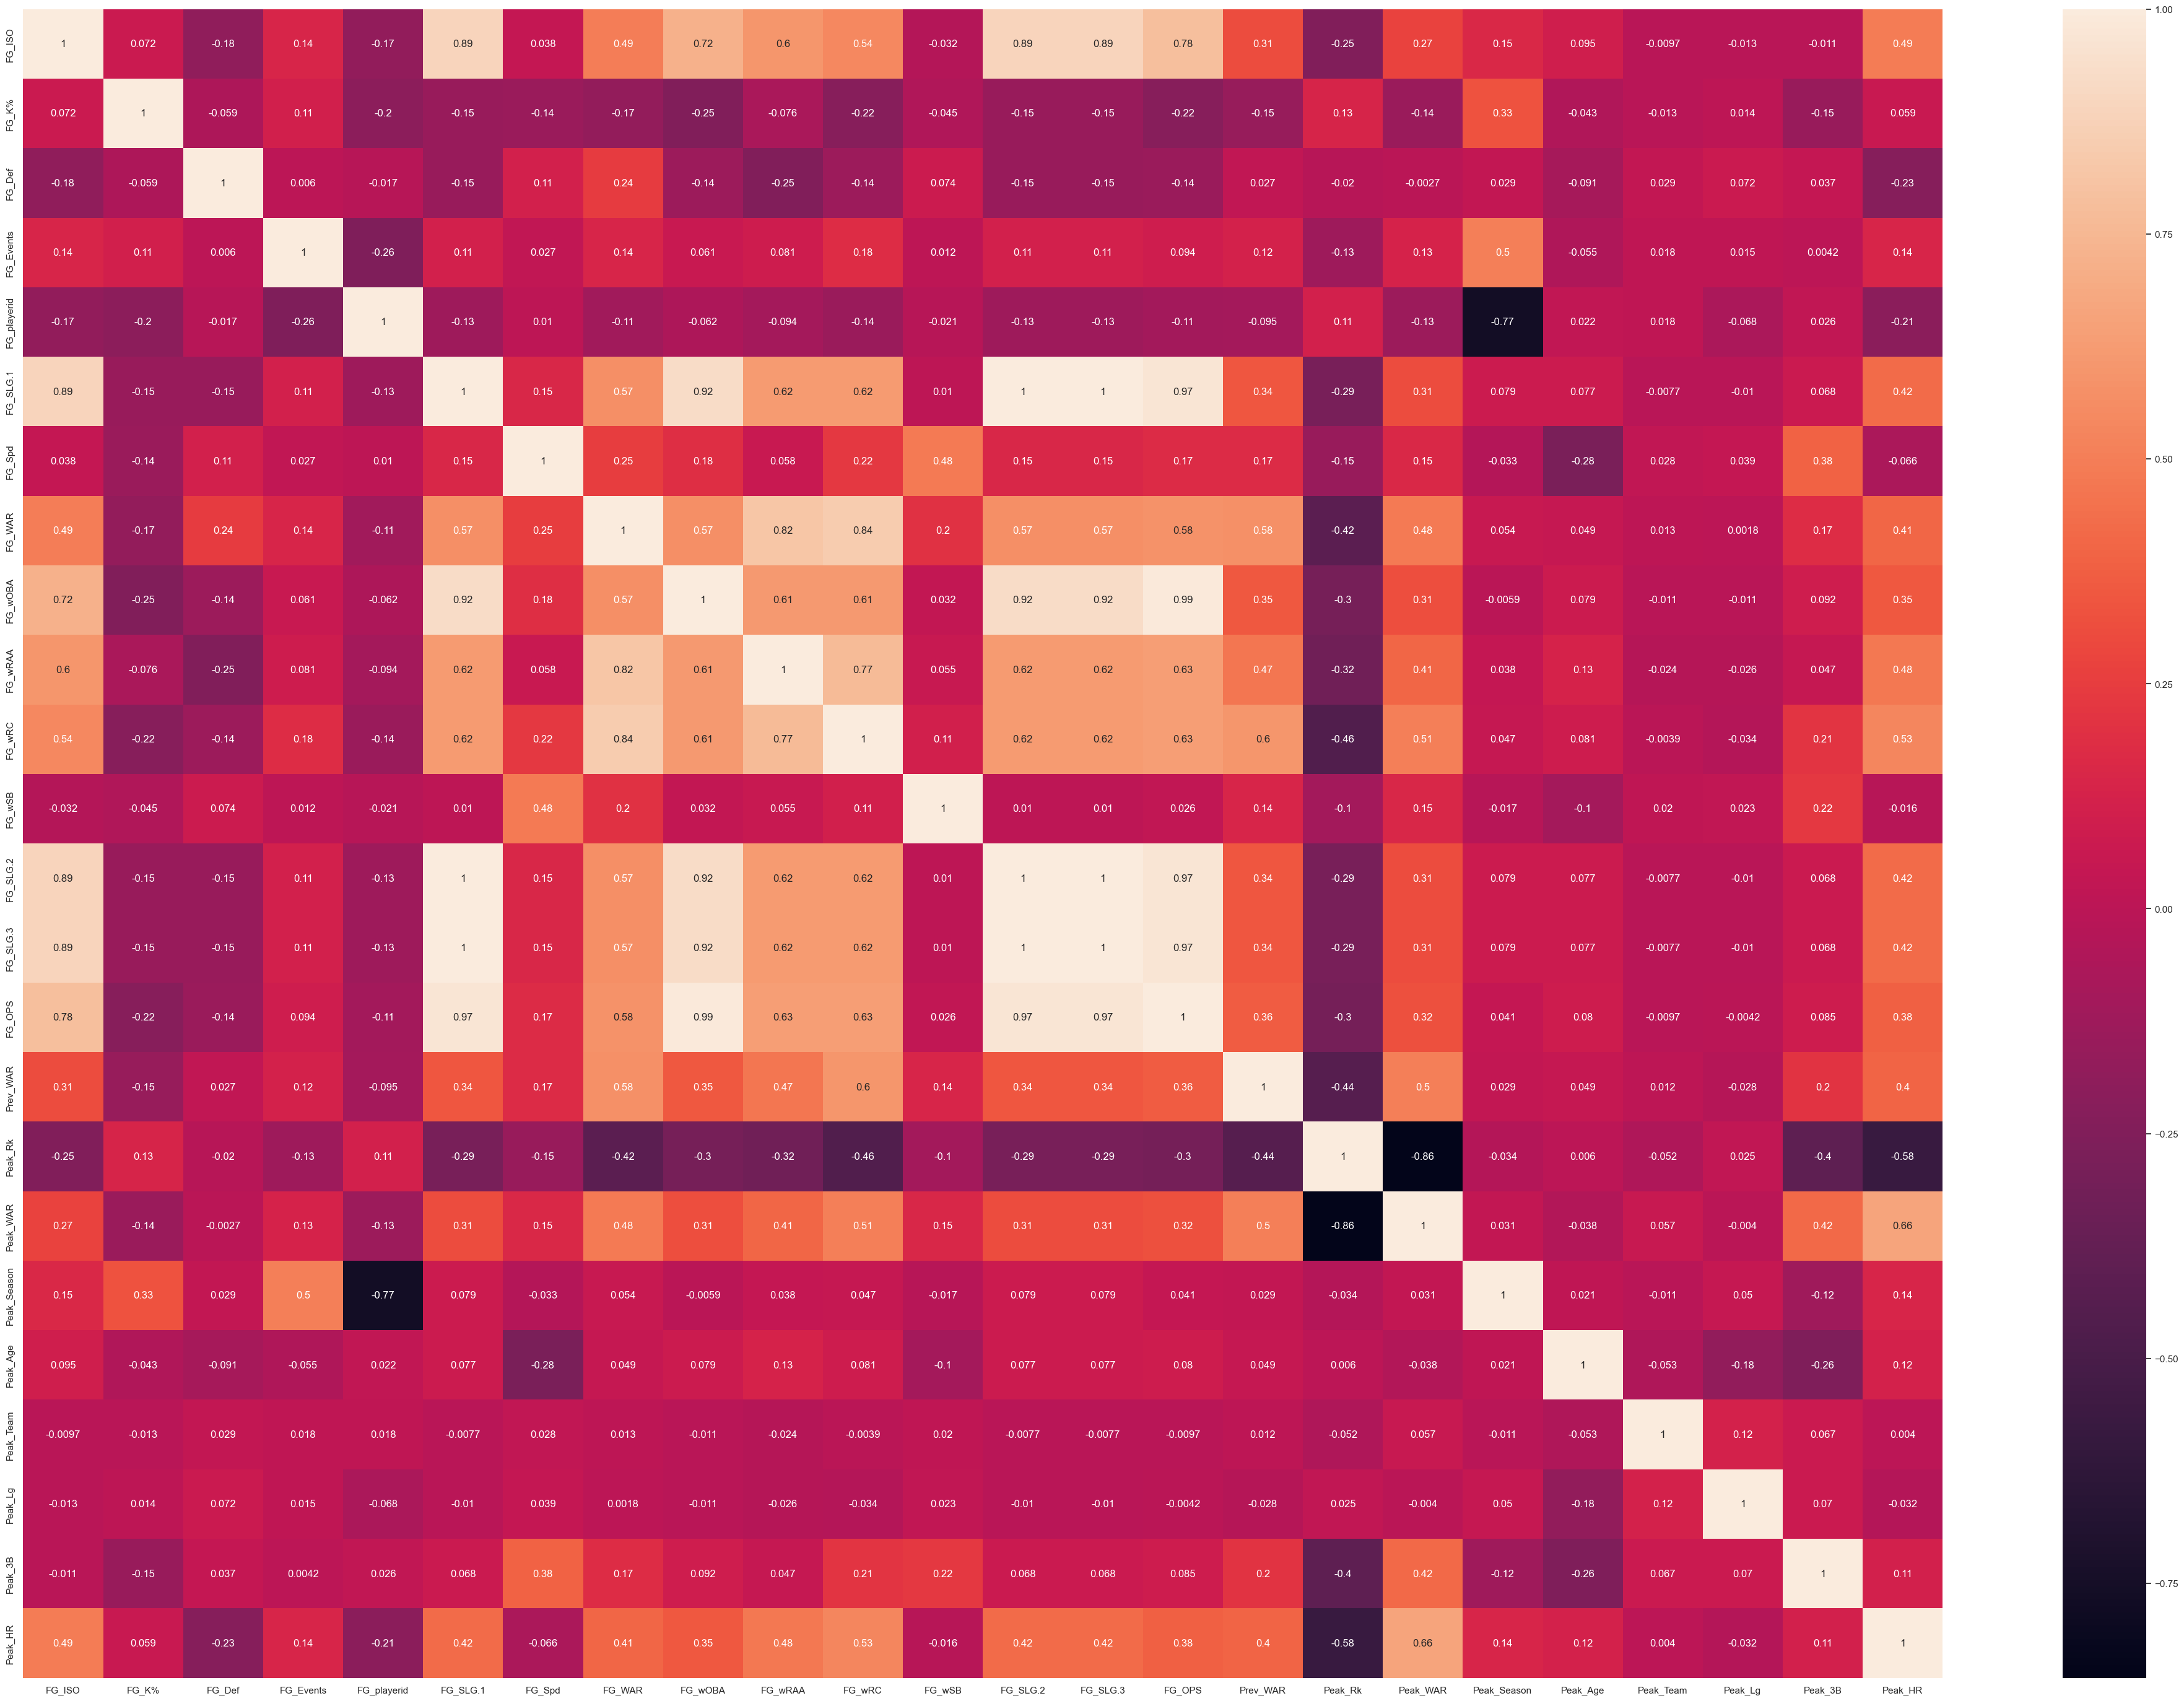

In [422]:
#correlation
X = ss_pos_df_train_2_2.values
N, M = X.shape
#Average of features
Xavg = np.zeros(M) 
for i in range(M):
    Xavg[i] = ss_pos_df_train_2_2.iloc[:,i].mean()

Xcor = np.zeros((M,M))
for x in range(M):
    for y in range(M):
        Xcor[x,y] = np.sum((X[:,x] - Xavg[x]) * (X[:,y] - Xavg[y])) / ((np.sqrt(np.sum((X[:,x] - Xavg[x])**2))) * (np.sqrt(np.sum((X[:,y] - Xavg[y])**2))))

cols = ss_pos_df_train_2_2.columns
sns.heatmap(Xcor, annot=True, xticklabels=cols, yticklabels=cols)
sns.set(rc = {'figure.figsize':(50,35)})
plt.show()

In [423]:
#FG_WAR & FG_wRAA, FG_wRC
#FG_wOBA & FG_OPS

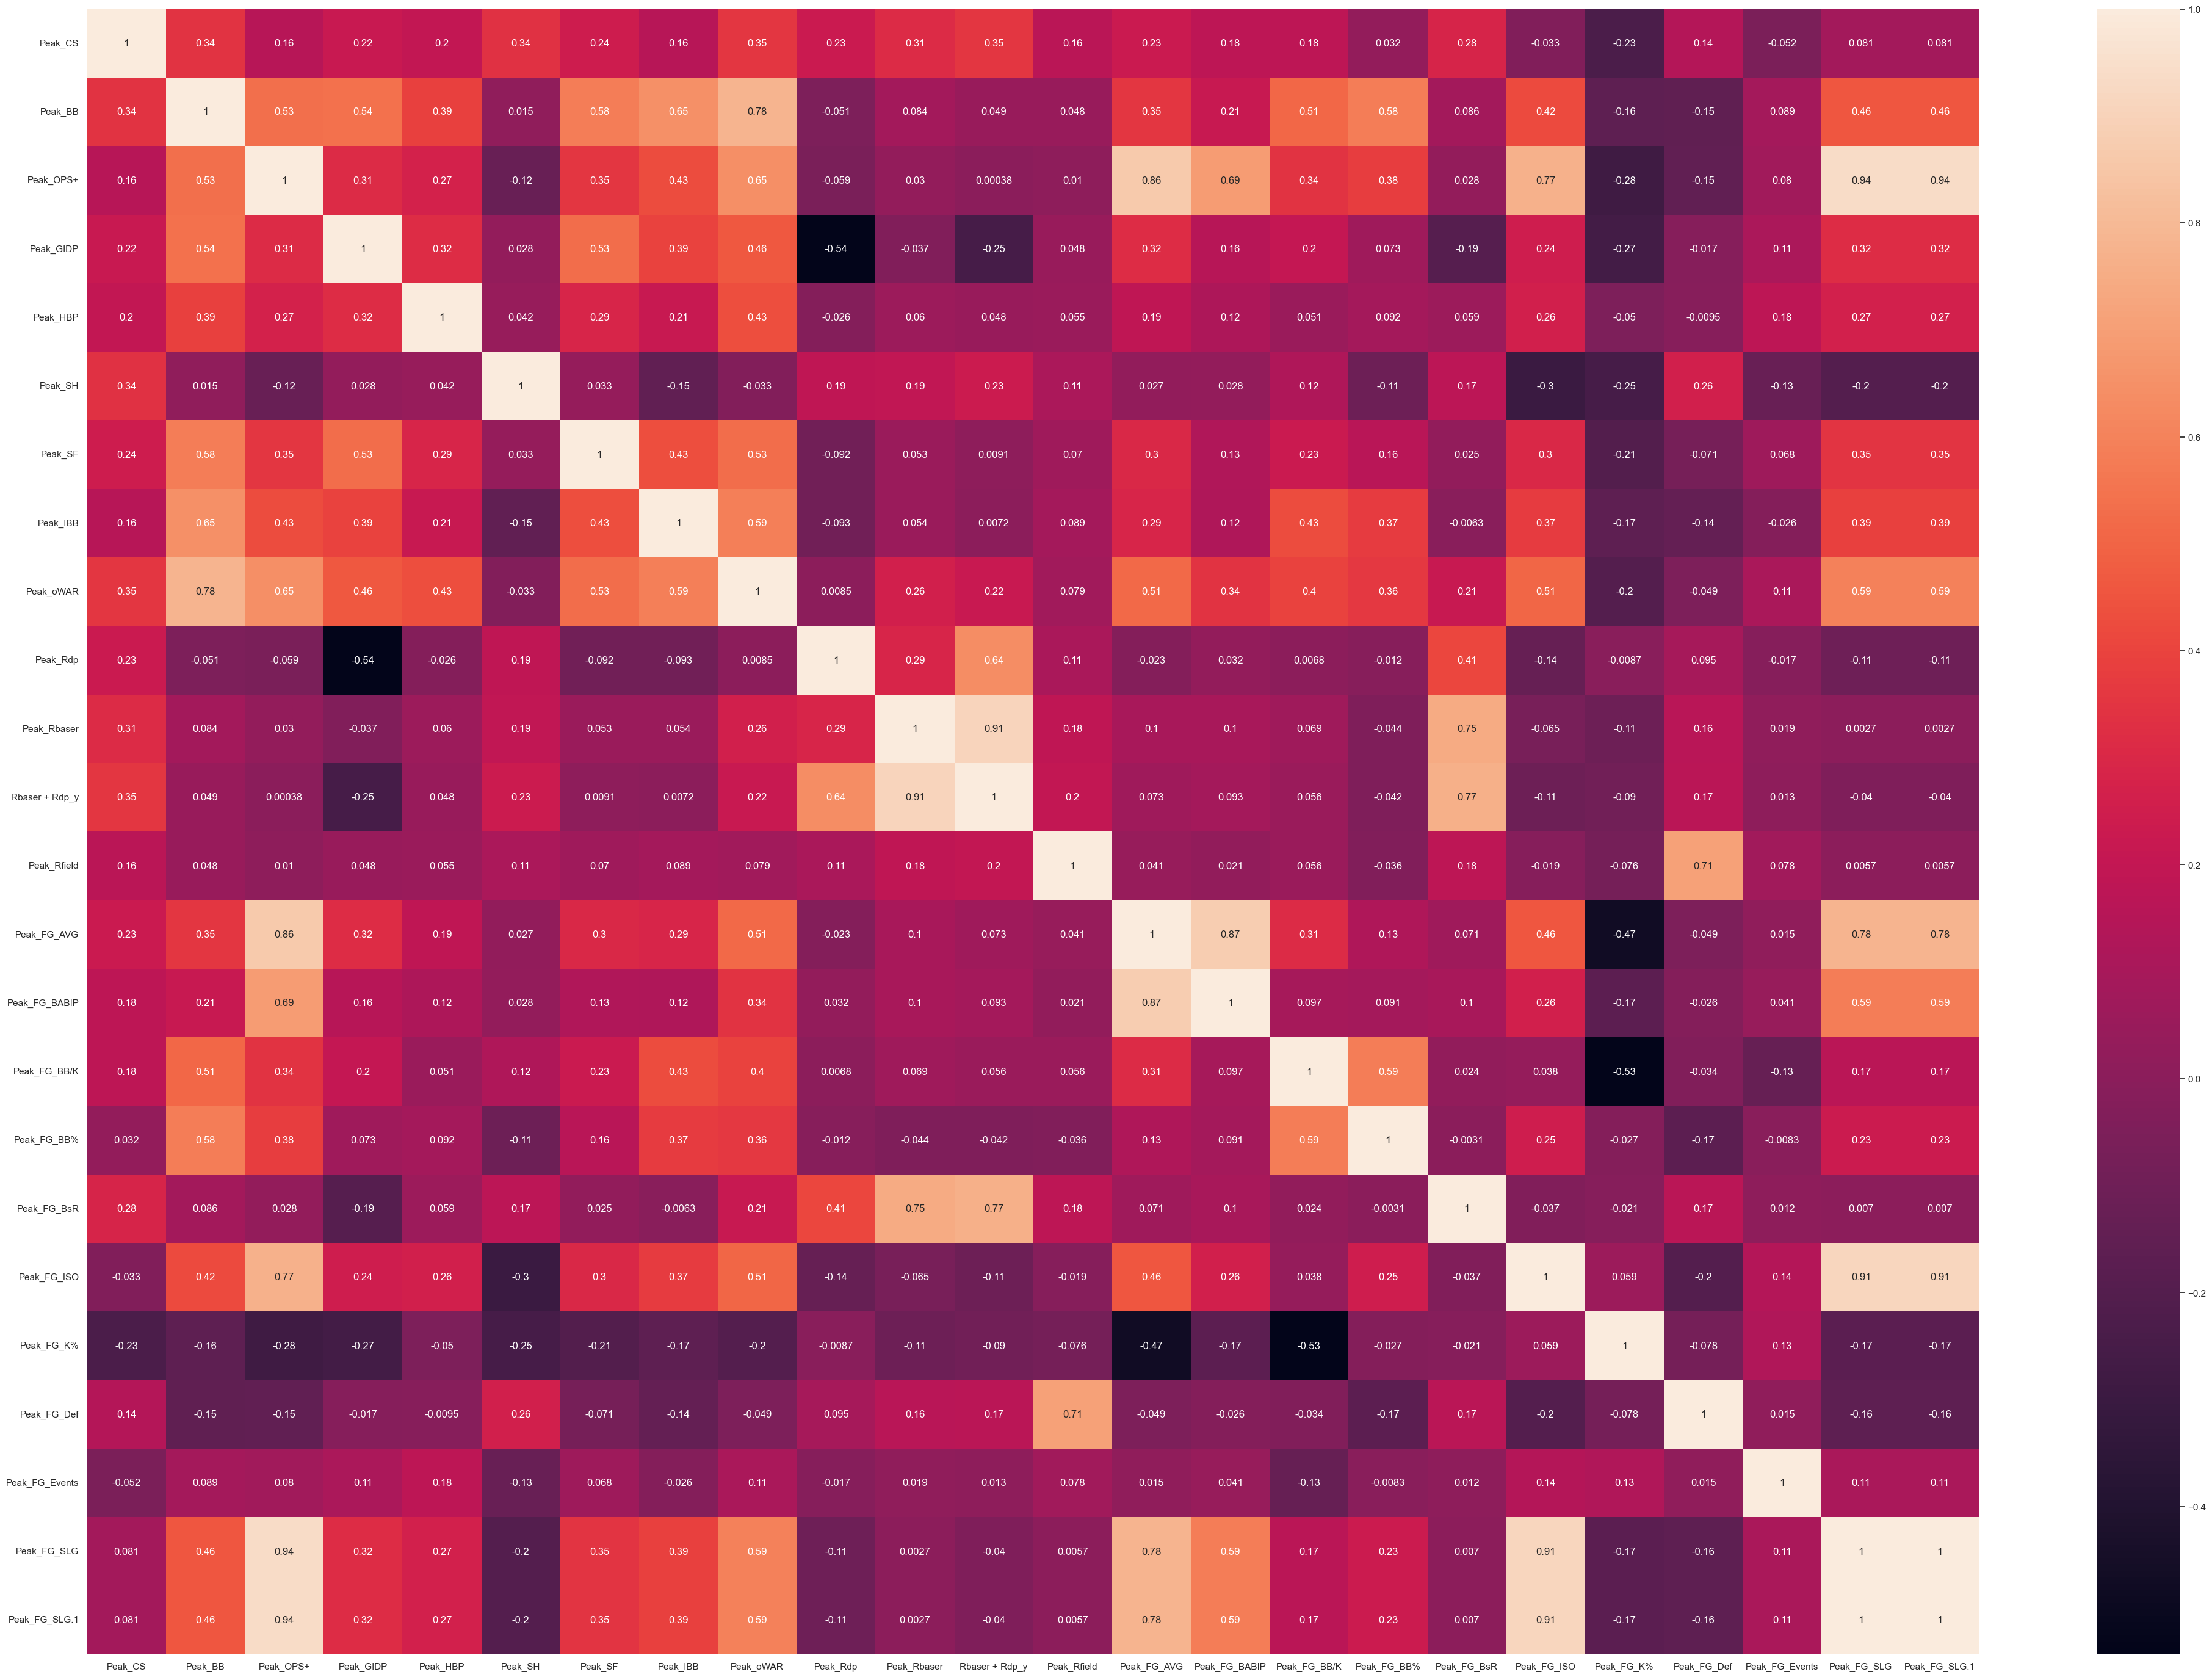

In [424]:
#correlation
X = ss_pos_df_train_2_3.values
N, M = X.shape
#Average of features
Xavg = np.zeros(M) 
for i in range(M):
    Xavg[i] = ss_pos_df_train_2_3.iloc[:,i].mean()

Xcor = np.zeros((M,M))
for x in range(M):
    for y in range(M):
        Xcor[x,y] = np.sum((X[:,x] - Xavg[x]) * (X[:,y] - Xavg[y])) / ((np.sqrt(np.sum((X[:,x] - Xavg[x])**2))) * (np.sqrt(np.sum((X[:,y] - Xavg[y])**2))))

cols = ss_pos_df_train_2_3.columns
sns.heatmap(Xcor, annot=True, xticklabels=cols, yticklabels=cols)
sns.set(rc = {'figure.figsize':(50,35)})
plt.show()

In [425]:
#Peak_oWAR & Peak_FG_WAR
#Peak_Rbaser & Rbaser + Rdp_y
#Peak_FG_AVG & Peak_FG_BABIP, Peak_FG_wOBA
#Peak_FG_ISO & Peak_FG_SLG, Peak_FG_SLG
#FG_SLG & Peak_FG_ISO, Peak_FG_wOBA
#Peak_FG_WAR & Peak_oWAR
#Peak_FG_wOBA & Peak_FG_AVG, Peak_FG_AVG

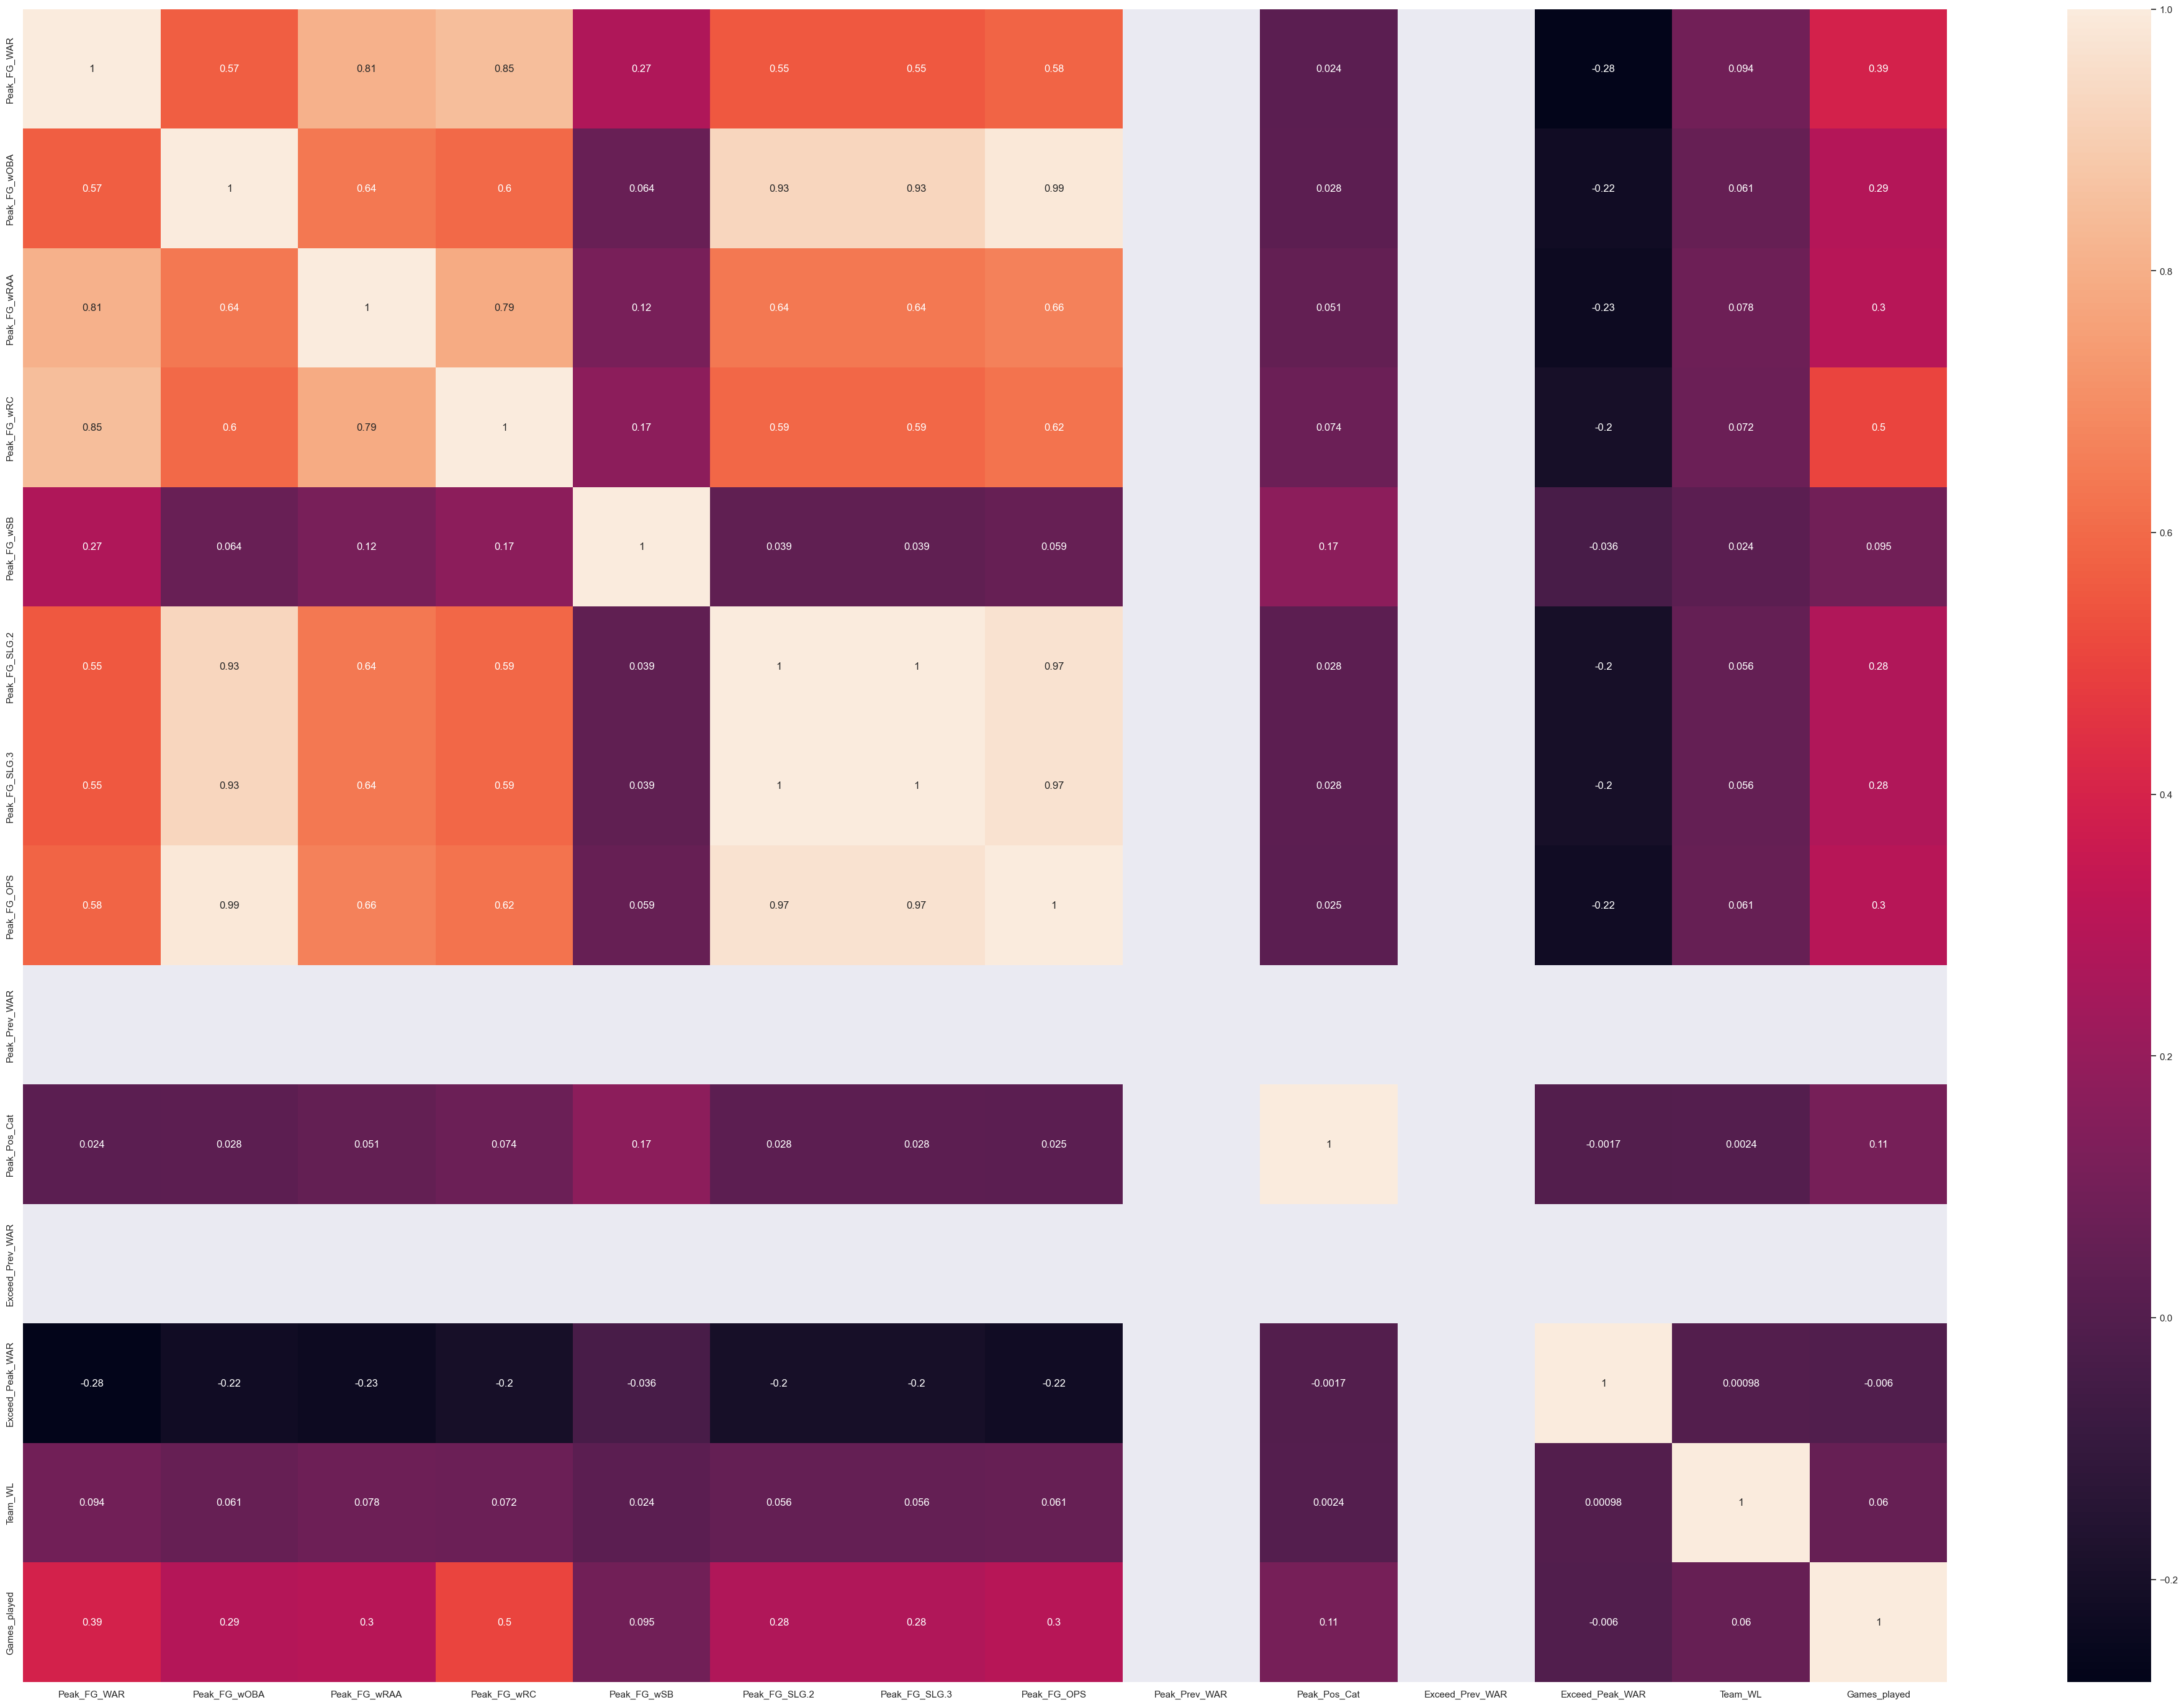

In [426]:
#correlation
X = ss_pos_df_train_2_4.values
N, M = X.shape
#Average of features
Xavg = np.zeros(M) 
for i in range(M):
    Xavg[i] = ss_pos_df_train_2_4.iloc[:,i].mean()

Xcor = np.zeros((M,M))
for x in range(M):
    for y in range(M):
        Xcor[x,y] = np.sum((X[:,x] - Xavg[x]) * (X[:,y] - Xavg[y])) / ((np.sqrt(np.sum((X[:,x] - Xavg[x])**2))) * (np.sqrt(np.sum((X[:,y] - Xavg[y])**2))))

cols = ss_pos_df_train_2_4.columns
sns.heatmap(Xcor, annot=True, xticklabels=cols, yticklabels=cols)
sns.set(rc = {'figure.figsize':(15,15)})
plt.show()

In [427]:
#Peak_FG_SLG
#WAR & oWAR
#FG_AVG & OPS+, FG_BABIP
#FG_WAR & FG_wRAA, FG_wRC
#FG_wOBA & FG_OPS
#Peak_oWAR & Peak_FG_WAR
#Peak_Rbaser & Rbaser + Rdp_y
#Peak_FG_AVG & Peak_FG_BABIP, Peak_FG_wOBA
#Peak_FG_ISO & Peak_FG_SLG, Peak_FG_SLG
#FG_SLG & Peak_FG_ISO, Peak_FG_wOBA
#Peak_FG_WAR & Peak_oWAR
#Peak_FG_wOBA & Peak_FG_AVG, Peak_FG_AVG

In [428]:
#drop highly correlated features
ss_pos_df_train_2 = ss_pos_df_train_2.drop(['Peak_FG_SLG','oWAR','FG_AVG', 'FG_WAR','FG_wOBA',
                                            'Rbaser + Rdp_y','Peak_Rbaser','Peak_oWAR', 'Peak_FG_WAR', 
                                            'Peak_FG_AVG','Peak_FG_wOBA'], axis=1)


In [429]:
#break into multiple datasets
ss_pos_df_train_2_1 = ss_pos_df_train_2.iloc[:, 0:25]
ss_pos_df_train_2_2 = ss_pos_df_train_2.iloc[:, 26:50]
ss_pos_df_train_2_3 = ss_pos_df_train_2.iloc[:, 51:75]
ss_pos_df_train_2_4 = ss_pos_df_train_2.iloc[:, 76:]

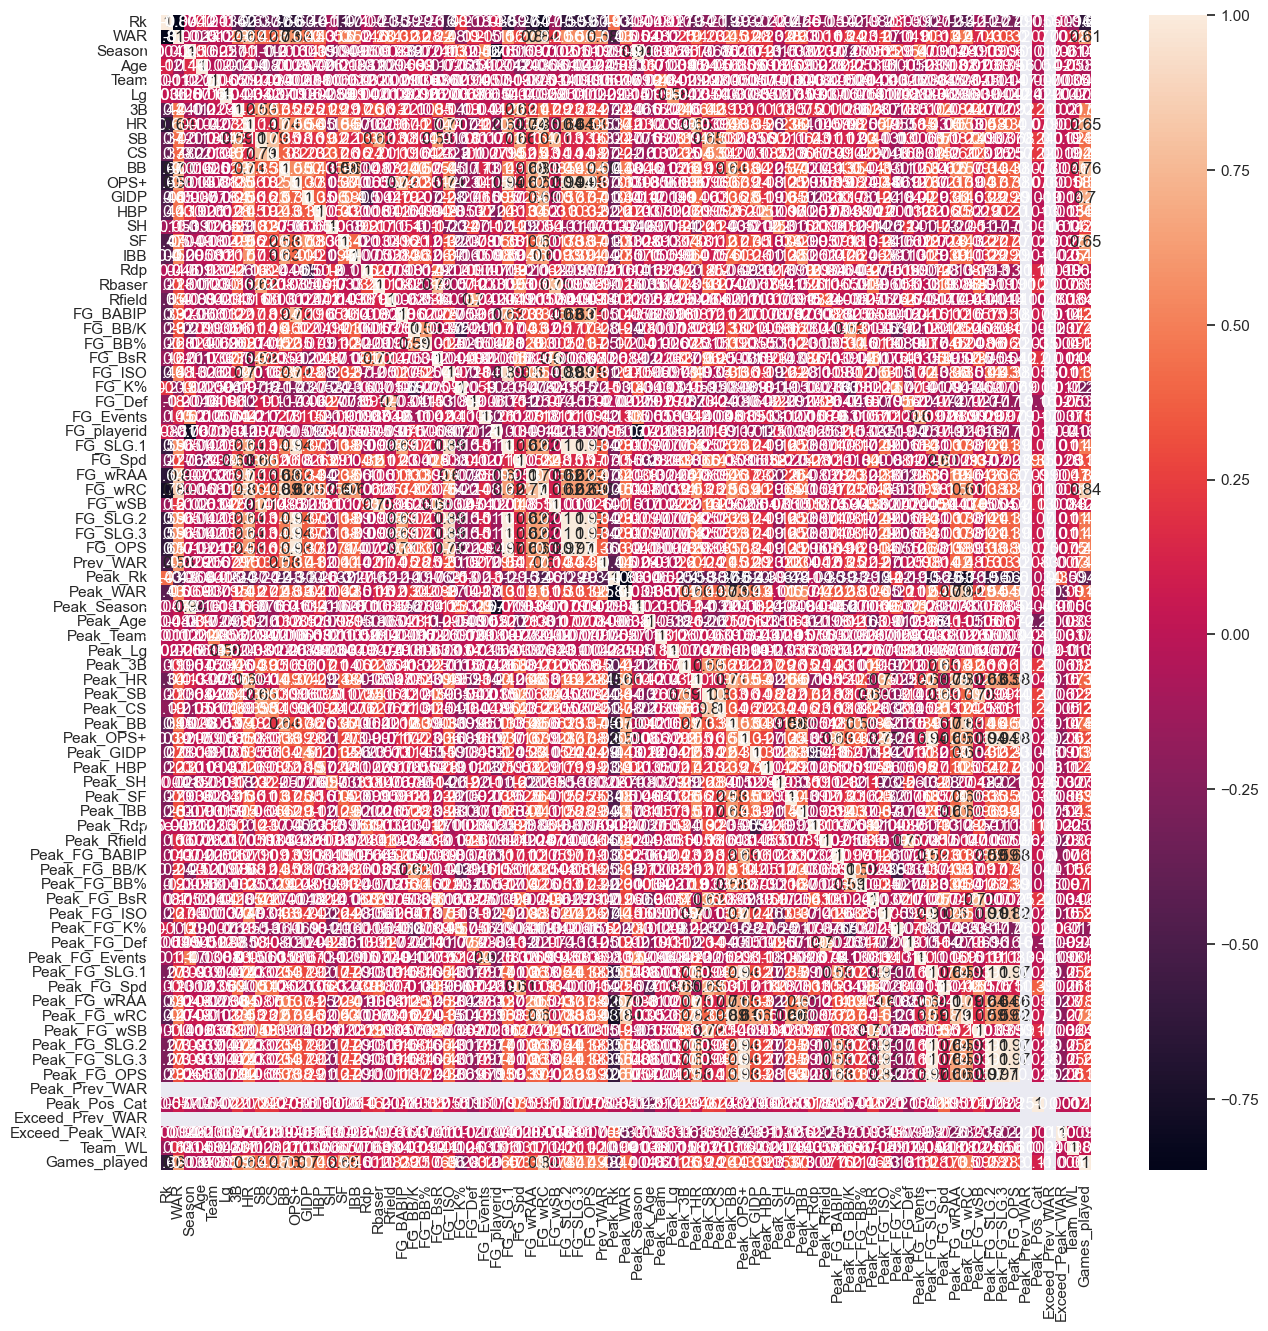

In [430]:
#correlation
X = ss_pos_df_train_2.values
N, M = X.shape
#Average of features
Xavg = np.zeros(M) 
for i in range(M):
    Xavg[i] = ss_pos_df_train_2.iloc[:,i].mean()

Xcor = np.zeros((M,M))
for x in range(M):
    for y in range(M):
        Xcor[x,y] = np.sum((X[:,x] - Xavg[x]) * (X[:,y] - Xavg[y])) / ((np.sqrt(np.sum((X[:,x] - Xavg[x])**2))) * (np.sqrt(np.sum((X[:,y] - Xavg[y])**2))))

cols = ss_pos_df_train_2.columns
sns.heatmap(Xcor, annot=True, xticklabels=cols, yticklabels=cols)
sns.set(rc = {'figure.figsize':(50,35)})
plt.show()

In [431]:
#Rk, Peak_Rk, FG_wRC, Peak_FG_wRC, FG_wRAA, Peak_FG_ISO, Peak_FG_OPS, FG_OPS remove
#Peak_FG_OPS & Peak_FG_ISO
#Peak_Season & Season
#FG_OPS & OPS+
#Peak_WAR & Peak_FG_wRC

In [432]:
#drop highly correlated features
ss_pos_df_train_2 = ss_pos_df_train_2.drop(["Rk","Peak_Rk","FG_wRC","Peak_FG_wRC","FG_wRAA",
                                            "Peak_FG_ISO","Peak_FG_OPS","FG_OPS"], axis=1)


In [433]:
ss_pos_df_train_2 = ss_pos_df_train_2.drop(["Peak_Season"], axis=1)

In [434]:
#drop rows where Peak_Prev_WAR are null
ss_pos_df_train_2 = ss_pos_df_train_2.dropna(subset=['Peak_Prev_WAR'])
ss_pos_df_train_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12224 entries, 2 to 15714
Data columns (total 70 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   WAR              12224 non-null  float64
 1   Season           12224 non-null  int64  
 2   Age              12224 non-null  int64  
 3   Team             12224 non-null  int64  
 4   Lg               12224 non-null  int64  
 5   3B               12224 non-null  int64  
 6   HR               12224 non-null  int64  
 7   SB               12224 non-null  int64  
 8   CS               12224 non-null  int64  
 9   BB               12224 non-null  int64  
 10  OPS+             12224 non-null  float64
 11  GIDP             12224 non-null  int64  
 12  HBP              12224 non-null  int64  
 13  SH               12224 non-null  int64  
 14  SF               12224 non-null  int64  
 15  IBB              12224 non-null  int64  
 16  Rdp              12224 non-null  int64  
 17  Rbaser      

In [435]:
#set x and y
ss_pos_df_X = ss_pos_df_train_2.loc[:, ss_pos_df_train_2.columns != 'Exceed_Peak_WAR'].values
ss_pos_df_y = ss_pos_df_train_2.loc[:, ss_pos_df_train_2.columns == 'Exceed_Peak_WAR'].values.ravel()

In [436]:
#set label encoder on y
label_encoder = LabelEncoder()
ss_pos_df_y_enc = label_encoder.fit_transform(ss_pos_df_y)

In [437]:
#function to split training set for testing porposes
def split_eval_docs(_clf, _Xdocs, _ydocs):
    X_train, X_test, y_train, y_test = train_test_split(_Xdocs, _ydocs, test_size=0.3, random_state=42)
    _clf.fit(X_train, y_train)
    y_pred = _clf.predict(X_test)
    return y_test, y_pred, X_test, X_train

In [438]:
#define RF pipeline
n_cores = 8
rf = Pipeline([('clf', RandomForestClassifier(n_jobs=n_cores, n_estimators=1000,
                                              max_depth=10, random_state=None, class_weight='balanced'))])

In [439]:
%%time

y_test, y_pred, X_test, X_train = split_eval_docs(rf, ss_pos_df_X, ss_pos_df_y_enc)
print('Random Forest\n' + classification_report(y_test, y_pred, target_names=['0','1']))

Random Forest
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2017
           1       0.99      0.97      0.98      1651

    accuracy                           0.98      3668
   macro avg       0.98      0.98      0.98      3668
weighted avg       0.98      0.98      0.98      3668

CPU times: user 15.9 s, sys: 331 ms, total: 16.2 s
Wall time: 2.51 s


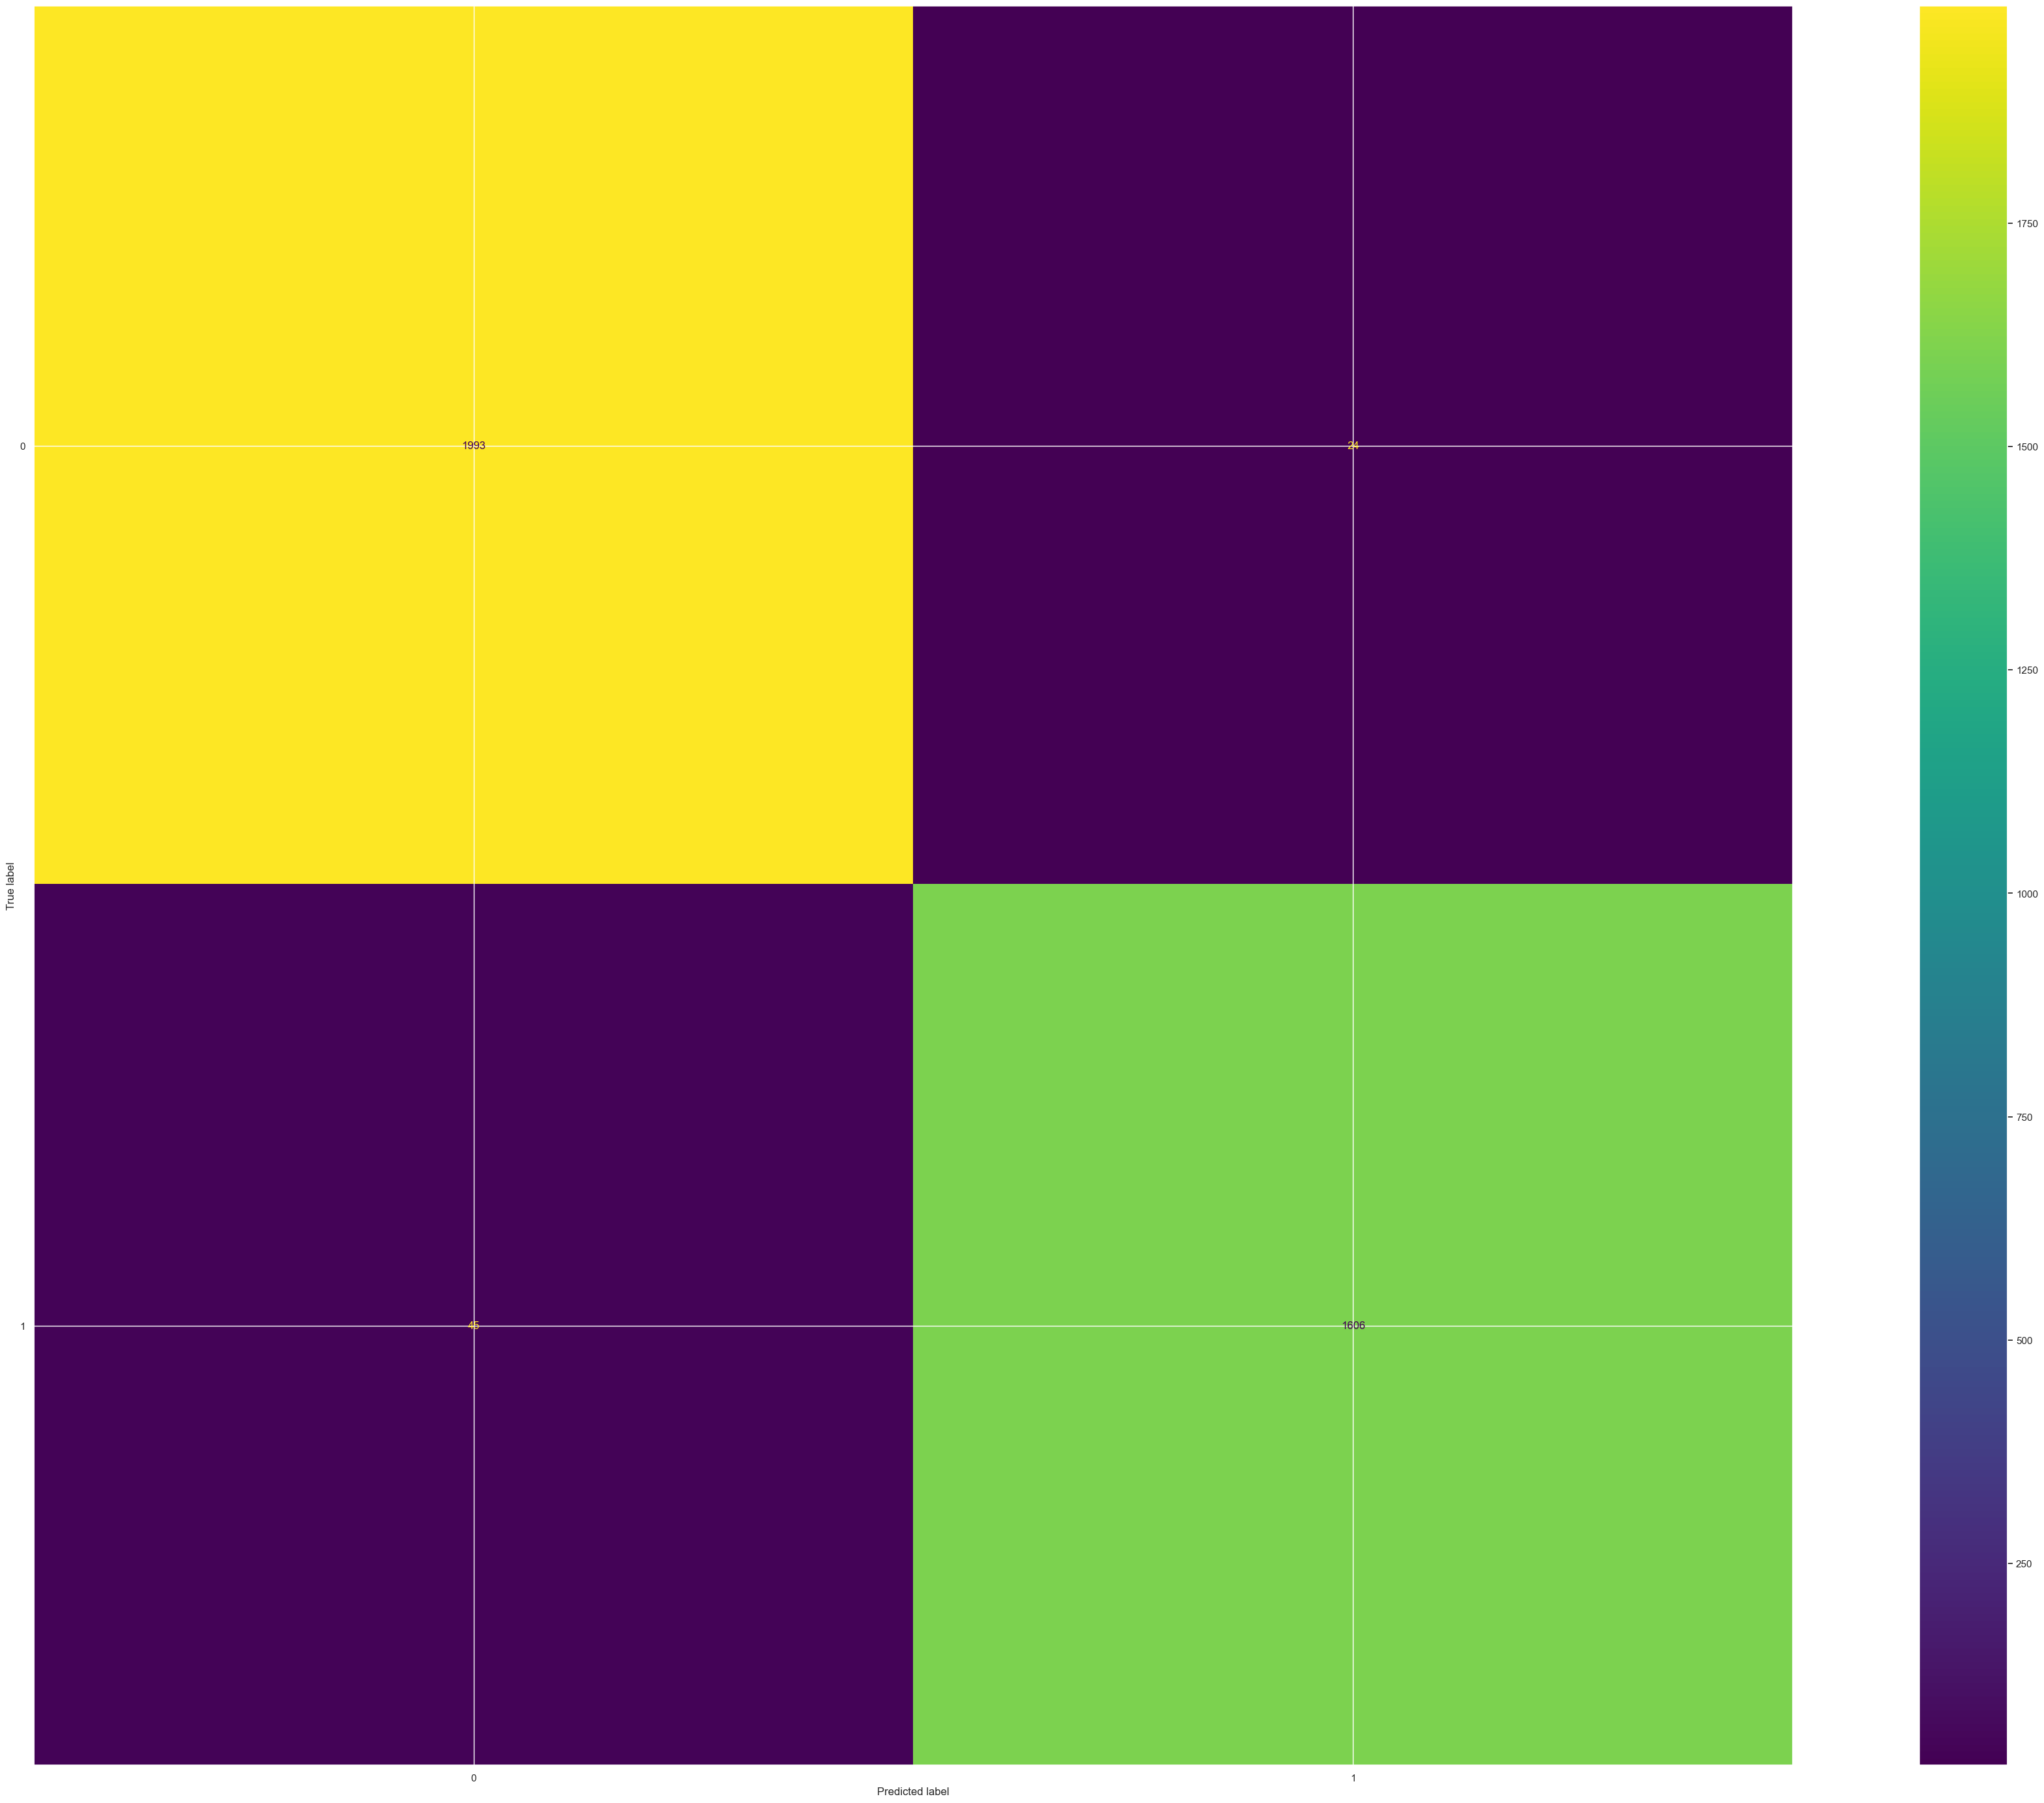

In [440]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [441]:
#drop highly correlated features for 2023 ds
ss_pos_df_2023_2 = ss_pos_df_2023_2.drop(['Peak_G','G','Peak_PA','PA','Peak_AB','AB','Peak_R','R','Peak_H',
                                            'H','Peak_1B','1B','Peak_2B','2B','Peak_RBI','RBI','Peak_SO','SO',
                                            'Peak_TB','TB','WAA','Peak_WAA','dWAR','Peak_dWAR','Rbat','Peak_Rbat',
                                            'FG_Bat','Peak_FG_Bat','FG_L-WAR','Peak_FG_L-WAR','Rbaser + Rdp_x',
                                            'FG_SLG','FG_OBP','Peak_FG_OBP','Peak_FG_SLG','oWAR','FG_AVG', 
                                            'FG_WAR','FG_wOBA','Rbaser + Rdp_y','Peak_Rbaser','Peak_oWAR', 
                                            'Peak_FG_WAR', 'Peak_FG_AVG','Peak_FG_wOBA','Rk','Peak_Rk','FG_wRC',
                                            'Peak_FG_wRC','FG_wRAA','Peak_FG_ISO','Peak_FG_OPS','FG_OPS'], axis=1)



In [442]:
ss_pos_df_2023_2 = ss_pos_df_2023_2.drop(["Peak_Season"], axis=1)

In [443]:
#confirm 2023 set
ss_pos_df_2023_2[["WAR","Season","Age","Team","Lg","3B","HR","SB","CS","BB","OPS+","GIDP","HBP","SH","SF","IBB","Rdp","Rbaser","Rfield","FG_BABIP","FG_BB/K","FG_BB%","FG_BsR","FG_ISO","FG_K%","FG_Def","FG_Events","FG_playerid","FG_Spd","FG_wSB","Prev_WAR","Peak_WAR","Peak_Age","Peak_Team","Peak_Lg","Peak_3B","Peak_HR","Peak_SB","Peak_CS","Peak_BB","Peak_OPS+","Peak_GIDP","Peak_HBP","Peak_SH","Peak_SF","Peak_IBB","Peak_Rdp","Peak_Rfield","Peak_FG_BABIP","Peak_FG_BB/K","Peak_FG_BB%","Peak_FG_BsR","Peak_FG_K%","Peak_FG_Def","Peak_FG_Events","Peak_FG_Spd","Peak_FG_wRAA","Peak_FG_wSB","Peak_Prev_WAR","Peak_Pos_Cat","Exceed_Prev_WAR","Exceed_Peak_WAR","Games_played","Team_WL"]]


WAR  Season  Age  Team  Lg  3B  HR  SB  CS  BB  ...  Peak_FG_Events  \
10447  1.3    2022   27    25   1   1  14  14   4  38  ...             238   
10449  6.4    2022   27    25   1   4  13  32   3  46  ...             468   
11977  2.1    2022   27     2   0   0  33   0   2  55  ...             457   
11978  3.4    2022   27     2   0   7  13  35   9  27  ...             354   
12349  3.0    2022   27    18   0   0   4  22   4  35  ...             419   
12559  1.3    2022   35    12   0   1   5   1   1  31  ...             215   
12563  4.5    2022   28    12   0   0  23   1   2  87  ...             481   
12564  1.3    2022   27    12   0   2  14   4   3  46  ...             254   
12646 -0.3    2022   29     7   1   0   5   0   0  16  ...              82   
12649 -0.3    2022   27     7   1   0   0   0   0   1  ...              20   
12650  0.6    2022   27     7   1   0  12   4   1  26  ...             164   
12651 -1.3    2022   27     7   1   0   5   8   5  30  ...             309   
12681 -0.8    2022   27    19   0   0   1   0   0   4  ...              37   
12682  1.7    2022   29    19   0   3  25  11   2  51  ...             355   
12758  3.9    2022   30     5   1   2  22   4   2  45  ...             315   
12759  0.1    2022   27     5   1   0   0   1   0   7  ...              26   
12760 -0.6    2022   27     5   1   0   0   1   0   7  ...              35   
12761  4.4    2022   27     5   1   2  17   9   4  58  ...             428   
12762  0.0    2022   29     5   1   1   6   0   0  22  ...             147   
12863  2.8    2022   27    23   0   3   6   3   2  68  ...             445   
12897 -0.1    2022   30    14   1   0   0   0   0   0  ...               1   
12899 -0.1    2022   29    14   1   2   2   0   1   3  ...             131   
13017  0.0    2022   28    24   1   1   4   1   1  10  ...              70   
13040  1.4    2022   27     4   0   0   9  17   1  15  ...             212   
13041 -0.1    2022   30     4   0   0   1   0   0   4  ...              27   
13073  1.5    2022   27    26   0   2   4   7   3  24  ...             269   
13074  2.8    2022   27    26   0   3  20  32  12  46  ...             432   
13075  0.3    2022   27    26   0   0   1   0   0   7  ...              38   
13081  2.5    2022   29     3   0   0  16  13   0  32  ...             239   
13084  0.2    2022   27     3   0   0   0   0   0   3  ...              13   
13138  2.9    2022   29    20   1   2  30   2   1  72  ...             425   
13215 -0.2    2022   35     9   1   6  16   4   1  32  ...             428   
13221 -1.1    2022   27     9   1   3   2  12   2  21  ...             141   
13251  1.1    2022   35    15   1   0  17   8   6  57  ...             395   
13258  0.5    2022   28    15   1   0   6   2   0  14  ...              93   
13297  0.6    2022   28    10   0   2  13   0   1  28  ...             324   
13299  0.7    2022   27    10   0   2   0   0   1  16  ...             111   
13303  0.2    2022   27    22   1   0   2   0   0  10  ...             119   
13318 -0.4    2022   27     1   1   0   3   0   0   6  ...              58   
13324  5.4    2022   27    16   0   1  22   0   1  61  ...             405   
13331 -0.1    2022   27    27   0   0   3   3   2   7  ...              64   
13336  0.0    2022   27    21   1   0   0   0   0   0  ...               2   
13338  2.9    2022   27    21   1   4  27   7   3  56  ...             403   
13350  3.2    2022   28     0   1   1   9  23   3  55  ...             355   
13372  2.7    2022   27     8   0   3   0  21   1  54  ...             454   

       Peak_FG_Spd  Peak_FG_wRAA  Peak_FG_wSB  Peak_Prev_WAR  Peak_Pos_Cat  \
10447          5.9          -0.7          0.8            6.3             5   
10449          7.2           3.9          4.6            3.7             4   
11977          1.6          13.3         -1.4            0.2             5   
11978          8.4         -12.1          3.0           -0.4             4   
12349          5.2         -

In [444]:
#function to check 2023 data
def set_final_docs(_clf, _Xdocs, _ydocs, _Xfinal):
    _clf.fit(_Xdocs, _ydocs)
    y_pred = _clf.predict(_Xfinal)
    return y_pred, _Xfinal

In [445]:
#set x and y
ss_pos_df_X_2023 = ss_pos_df_2023_2.loc[:, ss_pos_df_2023_2.columns != 'Exceed_Peak_WAR'].values

In [446]:
%%time
#run set_final_docs
y_pred, X_final = set_final_docs(rf, ss_pos_df_X, ss_pos_df_y_enc, ss_pos_df_X_2023)


CPU times: user 20.7 s, sys: 225 ms, total: 20.9 s
Wall time: 2.95 s


In [448]:
print('Exceed 2022 WAR in 2023?\t2022 WAR\tPlayer ID\t2023 Age\tPlayer')
for i in range(len(X_final)):
    print(str(y_pred[i]) + '\t\t\t\t' + str(X_final[i][0]) + '\t\t' + str(X_final[i][27]) + '\t\t\t' + str(X_final[i][2] + 1) + '\t' + ss_pos_df_2023_2_player[i])
    

Exceed 2022 WAR in 2023?	2022 WAR	Player ID	2023 Age	Player
1				1.3		15711.0			28.0	Tyler O'Neill
0				6.4		19470.0			28.0	Tommy Edman
0				2.1		14551.0			28.0	Anthony Santander
0				3.4		17273.0			28.0	Jorge Mateo
1				3.0		16512.0			28.0	Isiah Kiner-Falefa
0				1.3		4106.0			36.0	Michael Brantley
0				4.5		17678.0			29.0	Alex Bregman
1				1.3		19599.0			28.0	Chas McCormick
1				-0.3		16909.0			30.0	Colin Moran
1				-0.3		17750.0			28.0	Max Schrock
1				0.6		19260.0			28.0	Jake Fraley
1				-1.3		19293.0			28.0	Nick Senzel
1				-0.8		15654.0			28.0	Billy McKinney
1				1.7		18171.0			30.0	Seth Brown
0				3.9		11609.0			31.0	Willson Contreras
0				0.1		15983.0			28.0	Jackson Frazier
1				-0.6		16285.0			28.0	Michael Hermosillo
0				4.4		17919.0			28.0	Ian Happ
1				0.0		18433.0			30.0	P.J. Higgins
0				2.8		15491.0			28.0	J.P. Crawford
1				-0.1		11470.0			31.0	Tony Wolters
1				-0.1		11902.0			30.0	Hanser Alberto
0				0.0		16686.0			29.0	Jason Vosler
1				1.4		14196.0			28.0	Andrew Vel

In [449]:
#add exceed
ss_pos_df_2023_2['Exceed_Peak_WAR'] = y_pred

In [456]:
#add player name
ss_pos_df_2023_2['Player'] = ss_pos_df_2023_2_player.values

In [458]:
#check Exceeds
ss_pos_df_2023_2[["FG_playerid","Player","Age","Prev_WAR","WAR","Exceed_Prev_WAR","Exceed_Peak_WAR"]][ss_pos_df_2023_2["Exceed_Peak_WAR"] == 1]


FG_playerid              Player  Age  Prev_WAR  WAR  Exceed_Prev_WAR  \
10447        15711       Tyler O'Neill   27       6.3  1.3              0.0   
12349        16512  Isiah Kiner-Falefa   27       3.7  3.0              0.0   
12564        19599      Chas McCormick   27       2.3  1.3              0.0   
12646        16909         Colin Moran   29       0.0 -0.3              0.0   
12649        17750         Max Schrock   27      -0.1 -0.3              0.0   
12650        19260         Jake Fraley   27       1.6  0.6              0.0   
12651        19293         Nick Senzel   27      -0.4 -1.3              0.0   
12681        15654      Billy McKinney   27       0.1 -0.8              0.0   
12682        18171          Seth Brown   29       1.4  1.7              1.0   
12760        16285  Michael Hermosillo   27       0.1 -0.6              0.0   
12762        18433        P.J. Higgins   29      -0.4  0.0              1.0   
12897        11470        Tony Wolters   30      -0.3 -0.1              1.0   
12899        11902      Hanser Alberto   29       0.4 -0.1              0.0   
13040        14196    Andrew Velazquez   27       0.0  1.4              1.0   
13041        17161        Chad Wallach   30      -0.8 -0.1              1.0   
13075        19354          Luke Raley   27      -0.5  0.3              1.0   
13215         7859    Charlie Blackmon   35       1.0 -0.2              0.0   
13221        19262     Garrett Hampson   27       0.7 -1.1              0.0   
13251         9847    Andrew McCutchen   35       1.4  1.1              0.0   
13258        19683       Mike Brosseau   28       1.0  0.5              0.0   
13297        13621   Jeimer Candelario   28       3.8  0.6              0.0   
13318        15958    Travis Demeritte   27       0.0 -0.4              0.0   
13331        19294          Nick Solak   27       1.0 -0.1              0.0   
13336        14329      Anthony Alford   27       0.4  0.0              0.0   

       Exceed_Peak_WAR  
10447                1  
12349                1  
12564                1  
12646                1  
12649                1  
12650                1  
12651                1  
12681                1  
12682                1  
12760                1  
12762                1  
12897                1  
12899                1  
13040                1  
13041                1  
13075                1  
13215                1  
13221                1  
13251                1  
13258                1  
13297                1  
13318                1  
13331                1  
13336                1

In [459]:
#check does not exceeds
ss_pos_df_2023_2[["FG_playerid","Player","Age","Prev_WAR","WAR","Exceed_Prev_WAR","Exceed_Peak_WAR"]][ss_pos_df_2023_2["Exceed_Peak_WAR"] == 0]


FG_playerid             Player  Age  Prev_WAR  WAR  Exceed_Prev_WAR  \
10449        19470        Tommy Edman   27       3.7  6.4              1.0   
11977        14551  Anthony Santander   27       0.2  2.1              1.0   
11978        17273        Jorge Mateo   27      -0.4  3.4              1.0   
12559         4106   Michael Brantley   35       2.5  1.3              0.0   
12563        17678       Alex Bregman   28       2.1  4.5              1.0   
12758        11609  Willson Contreras   30       4.1  3.9              0.0   
12759        15983    Jackson Frazier   27      -1.4  0.1              1.0   
12761        17919           Ian Happ   27       1.6  4.4              1.0   
12863        15491      J.P. Crawford   27       3.8  2.8              0.0   
13017        16686       Jason Vosler   28      -0.8  0.0              1.0   
13073        14712      Manuel Margot   27       2.8  1.5              0.0   
13074        19290    Randy Arozarena   27       4.1  2.8              0.0   
13081        12564       Trevor Story   29       4.2  2.5              0.0   
13084        19552       Jaylin Davis   27      -0.1  0.2              1.0   
13138        16472       Rhys Hoskins   29       2.0  2.9              1.0   
13299        15672     Austin Meadows   27       2.0  0.7              0.0   
13303        14553       Nomar Mazara   27      -0.3  0.2              1.0   
13324        14162      Carlos Correa   27       7.2  5.4              0.0   
13338        19326     Bryan Reynolds   27       6.0  2.9              0.0   
13350        19734         Josh Rojas   28       0.8  3.2              1.0   
13372        17620        Myles Straw   27      -0.4  2.7              1.0   

       Exceed_Peak_WAR  
10449                0  
11977                0  
11978                0  
12559                0  
12563                0  
12758                0  
12759                0  
12761                0  
12863                0  
13017                0  
13073                0  
13074                0  
13081                0  
13084                0  
13138                0  
13299                0  
13303                0  
13324                0  
13338                0  
13350                0  
13372                0

In [460]:
#export out
from pathlib import Path  
filepath = Path('ss_pos_df_2023_2_final_pred.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
ss_pos_df_2023_2.to_csv(filepath,index=False)  